# Combined feature selection pipeline

This notebook combines:

1. **MI-based feature clustering** (hierarchical clustering on pairwise feature MI)
2. **Representative feature selection** (1 representative per MI cluster)
3. **Curvature binning** (algebraic curvature thresholds → curvature clusters)
4. **Feature selection** using:
   - Backward (wrapper) selection (RF + SequentialFeatureSelector)
   - JMI (approx.)
   - CMIM (approx.)

All three selection methods are run **globally** and **per curvature cluster**.

Outputs (plots + CSVs) are written to the configured `OUTPUT_BASE_DIR/...` folder.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from flamekit.io_fronts import Case, load_fronts


## Config

This notebook reads both YAML configs (MI-clustering/JMI/CMIM and backward-selection) and merges them.
If a key exists in both files, the MI/JMI/CMIM YAML takes precedence.


In [2]:
PROJECT_ROOT = Path.cwd().resolve()

CFG_MI_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "Feature_selection_mi_cluster_jmi_cmim" / "Feature_selection_mi_cluster_jmi_cmim.yaml"
CFG_BW_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "Feature_selection_backward" / "Feature_selection_backward.yaml"

CFG_MI = yaml.safe_load(CFG_MI_PATH.read_text(encoding="utf-8")) if CFG_MI_PATH.exists() else {}
CFG_BW = yaml.safe_load(CFG_BW_PATH.read_text(encoding="utf-8")) if CFG_BW_PATH.exists() else {}

def cfg_get(key, default=None):
    if key in CFG_MI:
        return CFG_MI.get(key)
    return CFG_BW.get(key, default)

BASE_DIR = PROJECT_ROOT / Path(cfg_get("BASE_DIR"))
PHI = float(cfg_get("PHI"))
LAT_SIZE = str(cfg_get("LAT_SIZE"))
POST = bool(cfg_get("POST"))

TIME_STEPS = list(cfg_get("TIME_STEPS"))
ISOLEVEL = float(cfg_get("ISOLEVEL"))
TARGET_VAR = str(cfg_get("TARGET_VAR"))
TARGET_LABEL = str(cfg_get("TARGET_LABEL", TARGET_VAR))
HIST_BINS = int(cfg_get("HIST_BINS", 60))

CLUSTER_ON_SPATIAL = bool(cfg_get("CLUSTER_ON_SPATIAL", False))
CLUSTER_FEATURES_INCLUDE = set(cfg_get("CLUSTER_FEATURES_INCLUDE", []))
MODEL_FEATURES_INCLUDE = set(cfg_get("MODEL_FEATURES_INCLUDE", []))
FEATURES_EXCLUDE = set(cfg_get("FEATURES_EXCLUDE", []))

CURVATURE_COLUMN = str(cfg_get("CURVATURE_COLUMN"))
CURVATURE_BOUNDS = tuple(cfg_get("CURVATURE_BOUNDS"))
if len(CURVATURE_BOUNDS) != 2:
    raise ValueError("CURVATURE_BOUNDS must contain exactly two values")
N_CLUSTERS = len(CURVATURE_BOUNDS) + 1

# --- data/binning ---
MIN_CLUSTER_SAMPLES = int(cfg_get("MIN_CLUSTER_SAMPLES", 2000))
RANDOM_STATE = int(cfg_get("RANDOM_STATE", 0))
TEST_SIZE = float(cfg_get("TEST_SIZE", 0.25))

# --- model params ---
MODEL_PARAMS = dict(cfg_get("MODEL_PARAMS", {"n_estimators": 300, "n_jobs": -1}))
MODEL_PARAMS.setdefault("random_state", RANDOM_STATE)
MODEL_PARAMS.setdefault("n_jobs", -1)

# --- MI feature clustering ---
MI_TOPN_PLOT = int(cfg_get("MI_TOPN_PLOT", 50))
MI_CLUSTER_THRESHOLD = float(cfg_get("MI_CLUSTER_THRESHOLD", 0.9))
MI_CLUSTER_NORMALIZE = bool(cfg_get("MI_CLUSTER_NORMALIZE", True))
MI_CLUSTER_LINKAGE = str(cfg_get("MI_CLUSTER_LINKAGE", "average"))

# --- JMI/CMIM selection sizes ---
K_SELECT_GLOBAL = int(cfg_get("K_SELECT_GLOBAL", cfg_get("TOPK_REP_PRED", 4)))
K_SELECT_PER_CLUSTER = int(cfg_get("K_SELECT_PER_CLUSTER", cfg_get("TOPK_REP_PRED", 4)))

# --- backward selection sizes ---
BACKWARD_N_FEATURES_GLOBAL = int(cfg_get("BACKWARD_N_FEATURES_GLOBAL", 4))
BACKWARD_N_FEATURES_CLUSTER = int(cfg_get("BACKWARD_N_FEATURES_CLUSTER", 4))
SFS_SCORING = str(cfg_get("SFS_SCORING", "neg_root_mean_squared_error"))
SFS_CV_SPLITS = int(cfg_get("SFS_CV_SPLITS", 5))

# --- output ---
OUTPUT_BASE_DIR = PROJECT_ROOT / Path(cfg_get("OUTPUT_BASE_DIR", cfg_get("OUTPUT_BASE_DIR", "outputs")))
PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"

def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    return f"t_{min(time_steps)}_to_{max(time_steps)}"

RUN_DIR = OUTPUT_BASE_DIR / PHI_TAG / LAT_TAG / _time_steps_tag(TIME_STEPS)
SAVE_DIR = RUN_DIR
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Using BASE_DIR: {BASE_DIR}")
print(f"[INFO] Saving outputs to: {SAVE_DIR}")


[INFO] Using BASE_DIR: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/isocontours
[INFO] Saving outputs to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/Feature_selection_mi_cluster_jmi_cmim/phi_0.4/h400x100_ref/t_198_to_201


## Plot style + saving

In [3]:
# =========================
# PLOT STYLE
# =========================
PLOT_FONT_FAMILY = str(cfg_get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(cfg_get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(cfg_get("FIG_DPI", 250))
FIG_SIZE_RAW = cfg_get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(cfg_get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = cfg_get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

COLOR_DATA = str(cfg_get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(cfg_get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(cfg_get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(cfg_get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(cfg_get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(cfg_get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"

ISO_FIG_SIZE = (7.6, 7.6)
SCATTER_S_ISO = 10
ALPHA_ISO = 0.6
LINE_WIDTH = 2.2
PRED_SCATTER_S = 18
PRED_ALPHA = 0.6
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

def _latexify_feature(label: str) -> str:
    if label in {"curvature", CURVATURE_COLUMN} or label.lower() == "kappa":
        return r"$\kappa$"
    if label.lower() in {"vorticity", "omega"}:
        return r"$\omega$"
    if label.lower() in {"tangential_strain_rate", "a_t_tang", "a_t_tangential"}:
        return r"$a_t^{tang}$"
    if label.lower() in {"normal_strain_rate", "a_t_norm", "a_t_normal"}:
        return r"$a_t^{norm}$"
    if label.lower() in {"u_n"}:
        return r"$u_n$"
    if label.lower() in {"u_t"}:
        return r"$u_t$"
    if label.startswith("$") and label.endswith("$"):
        return label
    import re
    m = re.fullmatch(r"d2([A-Za-z0-9_]+)d([xyz])2", label)
    if m:
        var = m.group(1)
        axis = m.group(2)
        return rf"$\frac{{\partial^2 {var}}}{{\partial {axis}^2}}$"
    m = re.fullmatch(r"d([A-Za-z0-9_]+)d([xyz])", label)
    if m:
        var = m.group(1)
        axis = m.group(2)
        return rf"$\frac{{\partial {var}}}{{\partial {axis}}}$"
    label = label.replace("d/dx", r"$\frac{\partial}{\partial x}$")
    label = label.replace("d/dy", r"$\frac{\partial}{\partial y}$")
    label = label.replace("d/dz", r"$\frac{\partial}{\partial z}$")
    label = label.replace("d2/dx2", r"$\frac{\partial^2}{\partial x^2}$")
    label = label.replace("d2/dy2", r"$\frac{\partial^2}{\partial y^2}$")
    label = label.replace("d2/dz2", r"$\frac{\partial^2}{\partial z^2}$")
    return label



def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI) -> None:
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.gcf().savefig(fname.with_suffix(".pdf"), bbox_inches="tight")


def save_then_show(stem: str, dpi: int = FIG_DPI) -> None:
    save_png(stem, dpi=dpi)
    plt.show()


def _cluster_cmap_and_norm(n_clusters: int):
    from matplotlib.colors import ListedColormap, BoundaryNorm

    base_colors = [
        COLOR_DATA,
        COLOR_NEUTRAL,
        COLOR_PRED,
        COLOR_DATA_EDGE,
        COLOR_PRED_EDGE,
        COLOR_LINE,
    ]

    if n_clusters <= len(base_colors):
        colors = base_colors[:n_clusters]
    else:
        base = plt.get_cmap("tab20")
        colors = [base(i) for i in range(n_clusters)]

    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)
    return cmap, norm, boundaries


def plot_isocontour_scatter(df: pd.DataFrame, save_stem: str | None = None) -> None:
    if "x" not in df.columns or "y" not in df.columns:
        print("[WARN] Missing x/y for isocontour scatter; skipping.")
        return

    fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)

    if "cluster" in df.columns:
        cmap, norm, boundaries = _cluster_cmap_and_norm(N_CLUSTERS)
        sc = ax.scatter(
            df["y"],
            df["x"],
            c=df["cluster"].astype(int),
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            cmap=cmap,
            norm=norm,
            edgecolors="none",
            zorder=3,
        )
        cbar = fig.colorbar(
            sc,
            ax=ax,
            fraction=0.046,
            pad=0.03,
            ticks=np.arange(N_CLUSTERS),
            boundaries=boundaries,
            spacing="proportional",
            orientation="horizontal",
        )
        cbar.set_label("Cluster ID")
    else:
        ax.scatter(
            df["y"],
            df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.6,
            zorder=3,
        )

    ax.set_xlabel("y")
    ax.set_ylabel("x")
    style_axes(ax, equal=True)
    if save_stem is not None:
        save_png(save_stem)
    plt.show()
    plt.close(fig)


def plot_pred_vs_true(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: Optional[str] = None,
    save_stem: Optional[str] = None,
) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        y_true,
        y_pred,
        s=PRED_SCATTER_S,
        alpha=PRED_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    lim_min = float(min(y_true.min(), y_pred.min()))
    lim_max = float(max(y_true.max(), y_pred.max()))
    ax.plot(
        [lim_min, lim_max],
        [lim_min, lim_max],
        linestyle="--",
        color=COLOR_LINE,
        linewidth=LINE_WIDTH,
        label="1:1",
    )
    ax.set_xlabel(f"{LABEL_SD} (true)")
    ax.set_ylabel(f"{LABEL_SD} (pred)")
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax, equal=True)
    if save_stem:
        save_png(save_stem, dpi=FIG_DPI)
    plt.show()
    plt.close(fig)


## Core utilities

In [4]:
def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]


def resolve_features(
    df: pd.DataFrame,
    include: Optional[List[str] | set[str]],
    exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    feats = num if include is None else set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)


def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    return sorted(set.intersection(*feature_sets))


def evaluate_model_rf(
    X: np.ndarray,
    y: np.ndarray,
    test_size: float,
    random_state: int,
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    r2 = float(r2_score(yte, ypred))
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    return r2, rmse, yte, ypred


## MI feature clustering + representatives

In [5]:
def compute_feature_mi_matrix(df: pd.DataFrame, features: List[str], random_state: int = RANDOM_STATE) -> pd.DataFrame:
    if not features:
        return pd.DataFrame()
    data = df[features].dropna()
    if data.empty:
        print("[WARN] No non-NaN rows available for MI matrix.")
        return pd.DataFrame(index=features, columns=features, dtype=float)

    X = data.to_numpy()
    n_features = len(features)
    mi_mat = np.zeros((n_features, n_features), dtype=float)

    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            mi_ij = mutual_info_regression(Xi, X[:, j], random_state=random_state)[0]
            mi_mat[i, j] = mi_ij
            mi_mat[j, i] = mi_ij

    return pd.DataFrame(mi_mat, index=features, columns=features)


def plot_feature_mi_table(df: pd.DataFrame, features: List[str], stem: str, random_state: int = RANDOM_STATE) -> pd.DataFrame:
    if not features:
        print("[WARN] No features provided for MI plot.")
        return pd.DataFrame()

    mi_table = compute_feature_mi_matrix(df, features, random_state=random_state)
    if mi_table.empty:
        return mi_table

    vmax = float(np.nanmax(mi_table.to_numpy()))
    if vmax <= 0:
        vmax = 1.0

    fig, ax = plt.subplots(
        figsize=(0.35 * len(features) + 3, 0.35 * len(features) + 2),
        dpi=FIG_DPI,
        constrained_layout=True,
    )
    im = ax.imshow(mi_table.to_numpy(), vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))
    ax.set_xticklabels([_latexify_feature(f) for f in features], fontsize=max(PLOT_FONT_SIZE - 6, 6), rotation=60)
    ax.set_yticklabels([_latexify_feature(f) for f in features], fontsize=max(PLOT_FONT_SIZE - 6, 6), rotation=0)
    fig.colorbar(im, label="Mutual information")
    style_axes(ax)
    ax.grid(False)
    save_then_show(stem)

    print(f"[INFO] MI plot saved: {stem}")
    return mi_table


def plot_mi_dendrogram(
    mi: pd.DataFrame,
    stem: str,
    threshold: float | None = None,
    linkage_method: str = "average",
) -> None:
    if mi.empty:
        print("[WARN] MI table empty; skipping dendrogram.")
        return
    try:
        from scipy.cluster.hierarchy import linkage as hlinkage, dendrogram, set_link_color_palette
        from scipy.spatial.distance import squareform
    except ImportError:
        print("[WARN] scipy not available; skipping MI dendrogram.")
        return

    mat = mi.to_numpy().copy().astype(float)
    mat = np.nan_to_num(mat, nan=0.0)
    max_val = float(np.max(mat)) if mat.size else 0.0
    if max_val <= 0:
        print("[WARN] MI matrix all zeros; skipping dendrogram.")
        return

    np.fill_diagonal(mat, max_val)
    dist = max_val - mat
    np.fill_diagonal(dist, 0.0)

    condensed = squareform(dist, checks=False)
    Z = hlinkage(condensed, method=linkage_method)

    color_threshold = None
    if threshold is not None:
        color_threshold = max(0.0, min(max_val, max_val - float(threshold)))

    palette = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    set_link_color_palette(palette)

    fig, ax = plt.subplots(figsize=(0.35 * len(mi.columns) + 3, 6), dpi=FIG_DPI, constrained_layout=True)
    dendrogram(
        Z,
        labels=[_latexify_feature(f) for f in mi.columns],
        leaf_rotation=90,
        leaf_font_size=8,
        ax=ax,
        color_threshold=color_threshold,
        above_threshold_color=COLOR_LINE,
    )
    set_link_color_palette(None)
    ax.set_ylabel("MI distance (max - MI)")
    ax.set_xlabel("Feature")
    if color_threshold is not None:
        ax.axhline(color_threshold, color=COLOR_LINE, linestyle="--", linewidth=1.2)
    save_png(stem, dpi=FIG_DPI)
    plt.show()
    plt.close(fig)
    print(f"[INFO] MI dendrogram saved: {stem}")


def mi_feature_clusters(mi: pd.DataFrame, threshold: float, linkage: str = "average") -> List[List[str]]:
    if mi.empty:
        return []

    mat = mi.to_numpy().copy().astype(float)
    mat = np.nan_to_num(mat, nan=0.0)

    max_val = float(np.max(mat)) if mat.size else 0.0
    if max_val <= 0:
        return [[name] for name in mi.columns]

    np.fill_diagonal(mat, max_val)
    dist = max_val - mat
    np.fill_diagonal(dist, 0.0)

    dist_threshold = max(0.0, min(max_val, max_val - float(threshold)))
    names = list(mi.columns)

    try:
        from scipy.cluster.hierarchy import linkage as hlinkage, fcluster
        from scipy.spatial.distance import squareform
        condensed = squareform(dist, checks=False)
        Z = hlinkage(condensed, method=linkage)
        labels = fcluster(Z, t=dist_threshold, criterion="distance")
    except ImportError:
        print("[WARN] scipy not available; falling back to sklearn AgglomerativeClustering.")
        try:
            model = AgglomerativeClustering(
                n_clusters=None,
                linkage=linkage,
                metric="precomputed",
                distance_threshold=dist_threshold,
            )
        except TypeError:
            model = AgglomerativeClustering(
                n_clusters=None,
                linkage=linkage,
                affinity="precomputed",
                distance_threshold=dist_threshold,
            )
        labels = model.fit_predict(dist)

    clusters: List[List[str]] = []
    for label in sorted(set(labels)):
        feats = [names[i] for i in range(len(names)) if labels[i] == label]
        clusters.append(sorted(feats))
    return clusters


def select_representative_features(
    df: pd.DataFrame,
    clusters: List[List[str]],
    target_var: str,
    random_state: int = RANDOM_STATE,
) -> Tuple[List[str], pd.DataFrame, pd.Series]:
    if not clusters:
        return [], pd.DataFrame(), pd.Series(dtype=float)

    features = sorted({f for cluster in clusters for f in cluster})
    data = df[features + [target_var]].dropna()
    if data.empty:
        print("[WARN] No non-NaN rows available for representative MI.")
        return [], pd.DataFrame(), pd.Series(dtype=float)

    mi_vals = mutual_info_regression(
        data[features].to_numpy(),
        data[target_var].to_numpy(),
        random_state=random_state,
    )
    mi_series = pd.Series(mi_vals, index=features)

    rep_rows = []
    reps: List[str] = []
    for cl_id, cluster_feats in enumerate(clusters):
        avail = [f for f in cluster_feats if f in mi_series.index]
        if not avail:
            continue
        best = mi_series.loc[avail].idxmax()
        reps.append(best)
        rep_rows.append({
            "mi_cluster": cl_id,
            "n_features": int(len(cluster_feats)),
            "representative": best,
            "mi_target": float(mi_series.loc[best]),
            "features": ", ".join(cluster_feats),
        })

    rep_df = pd.DataFrame(rep_rows)
    return reps, rep_df, mi_series


## JMI / CMIM (approx.)

In [6]:
def _residualize(target: np.ndarray, cond: np.ndarray) -> np.ndarray:
    if cond.size == 0:
        return target
    X = np.column_stack([np.ones(len(target)), cond])
    coef, _, _, _ = np.linalg.lstsq(X, target, rcond=None)
    return target - X @ coef


def conditional_mi_residuals(
    target: np.ndarray,
    feature: np.ndarray,
    cond: np.ndarray,
    random_state: int = RANDOM_STATE,
) -> float:
    y_res = _residualize(target, cond)
    x_res = _residualize(feature, cond)
    mi_val = mutual_info_regression(x_res.reshape(-1, 1), y_res, random_state=random_state)[0]
    return float(mi_val)


def select_jmi_features(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    k_select: int,
    random_state: int = RANDOM_STATE,
) -> Tuple[List[str], Dict[int, pd.Series]]:
    if not features:
        return [], {}

    data = df[features + [target_var]].dropna()
    if data.empty:
        return [], {}

    y = data[target_var].to_numpy()
    X = data[features].to_numpy()
    base_mi = mutual_info_regression(X, y, random_state=random_state)
    base_series = pd.Series(base_mi, index=features)

    selected: List[str] = []
    remaining = list(features)
    history: Dict[int, pd.Series] = {}

    for step in range(min(k_select, len(remaining))):
        if not selected:
            rank = base_series.loc[remaining].sort_values(ascending=False)
        else:
            scores = {}
            cond_matrix = data[selected].to_numpy()
            for f in remaining:
                x = data[f].to_numpy()
                cond_scores = []
                for i in range(cond_matrix.shape[1]):
                    s_col = cond_matrix[:, [i]]
                    cond_scores.append(conditional_mi_residuals(y, x, s_col, random_state=random_state))
                scores[f] = float(base_series.loc[f] + np.mean(cond_scores))
            rank = pd.Series(scores).sort_values(ascending=False)

        history[step + 1] = rank
        best = rank.index[0]
        selected.append(best)
        remaining.remove(best)

    return selected, history


def select_cmim_features(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    k_select: int,
    random_state: int = RANDOM_STATE,
) -> Tuple[List[str], Dict[int, pd.Series]]:
    if not features:
        return [], {}

    data = df[features + [target_var]].dropna()
    if data.empty:
        return [], {}

    y = data[target_var].to_numpy()
    X = data[features].to_numpy()
    base_mi = mutual_info_regression(X, y, random_state=random_state)
    base_series = pd.Series(base_mi, index=features)

    selected: List[str] = []
    remaining = list(features)
    history: Dict[int, pd.Series] = {}

    for step in range(min(k_select, len(remaining))):
        if not selected:
            rank = base_series.loc[remaining].sort_values(ascending=False)
        else:
            scores = {}
            cond_matrix = data[selected].to_numpy()
            for f in remaining:
                x = data[f].to_numpy()
                cond_scores = []
                for i in range(cond_matrix.shape[1]):
                    s_col = cond_matrix[:, [i]]
                    cond_scores.append(conditional_mi_residuals(y, x, s_col, random_state=random_state))
                scores[f] = float(np.min(cond_scores)) if cond_scores else float(base_series.loc[f])
            rank = pd.Series(scores).sort_values(ascending=False)

        history[step + 1] = rank
        best = rank.index[0]
        selected.append(best)
        remaining.remove(best)

    return selected, history


## Backward (wrapper) selection

In [7]:
def run_backward_selection(
    X: np.ndarray,
    y: np.ndarray,
    feature_names: List[str],
    n_features_to_select: int,
    random_state: int,
    scoring: str,
    cv_splits: int,
) -> List[str]:
    if X.shape[1] == 0:
        return []

    n_features_to_select = int(min(n_features_to_select, X.shape[1]))
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    model = RandomForestRegressor(**MODEL_PARAMS)
    sfs = SequentialFeatureSelector(
        estimator=model,
        n_features_to_select=n_features_to_select,
        direction="backward",
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
    )
    sfs.fit(X, y)
    mask = sfs.get_support()
    return [f for f, keep in zip(feature_names, mask) if keep]


## Load data

In [8]:
dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
if CLUSTER_ON_SPATIAL:
    cluster_include = cluster_include.union({"x", "y", "z"})

model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps. Adjust CLUSTER_FEATURES_INCLUDE.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps. Adjust MODEL_FEATURES_INCLUDE.")

print(f"Cluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR, CURVATURE_COLUMN}))
dfc = df_all.dropna(subset=required).copy()
print(f"After dropna on required (cluster+model+target): n={len(dfc)}")


Pooled rows total: n=13172 across timesteps=[198, 199, 200, 201]
Cluster features (common across all timesteps): ['curvature']
Model features (common across all timesteps):   ['curvature', 'dTdx', 'dTdy', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'du_tdx', 'du_tdy', 'normal_strain_rate', 'tangential_strain_rate', 'u_n', 'u_t', 'vorticity']
After dropna on required (cluster+model+target): n=13172


## Feature MI clustering + representatives

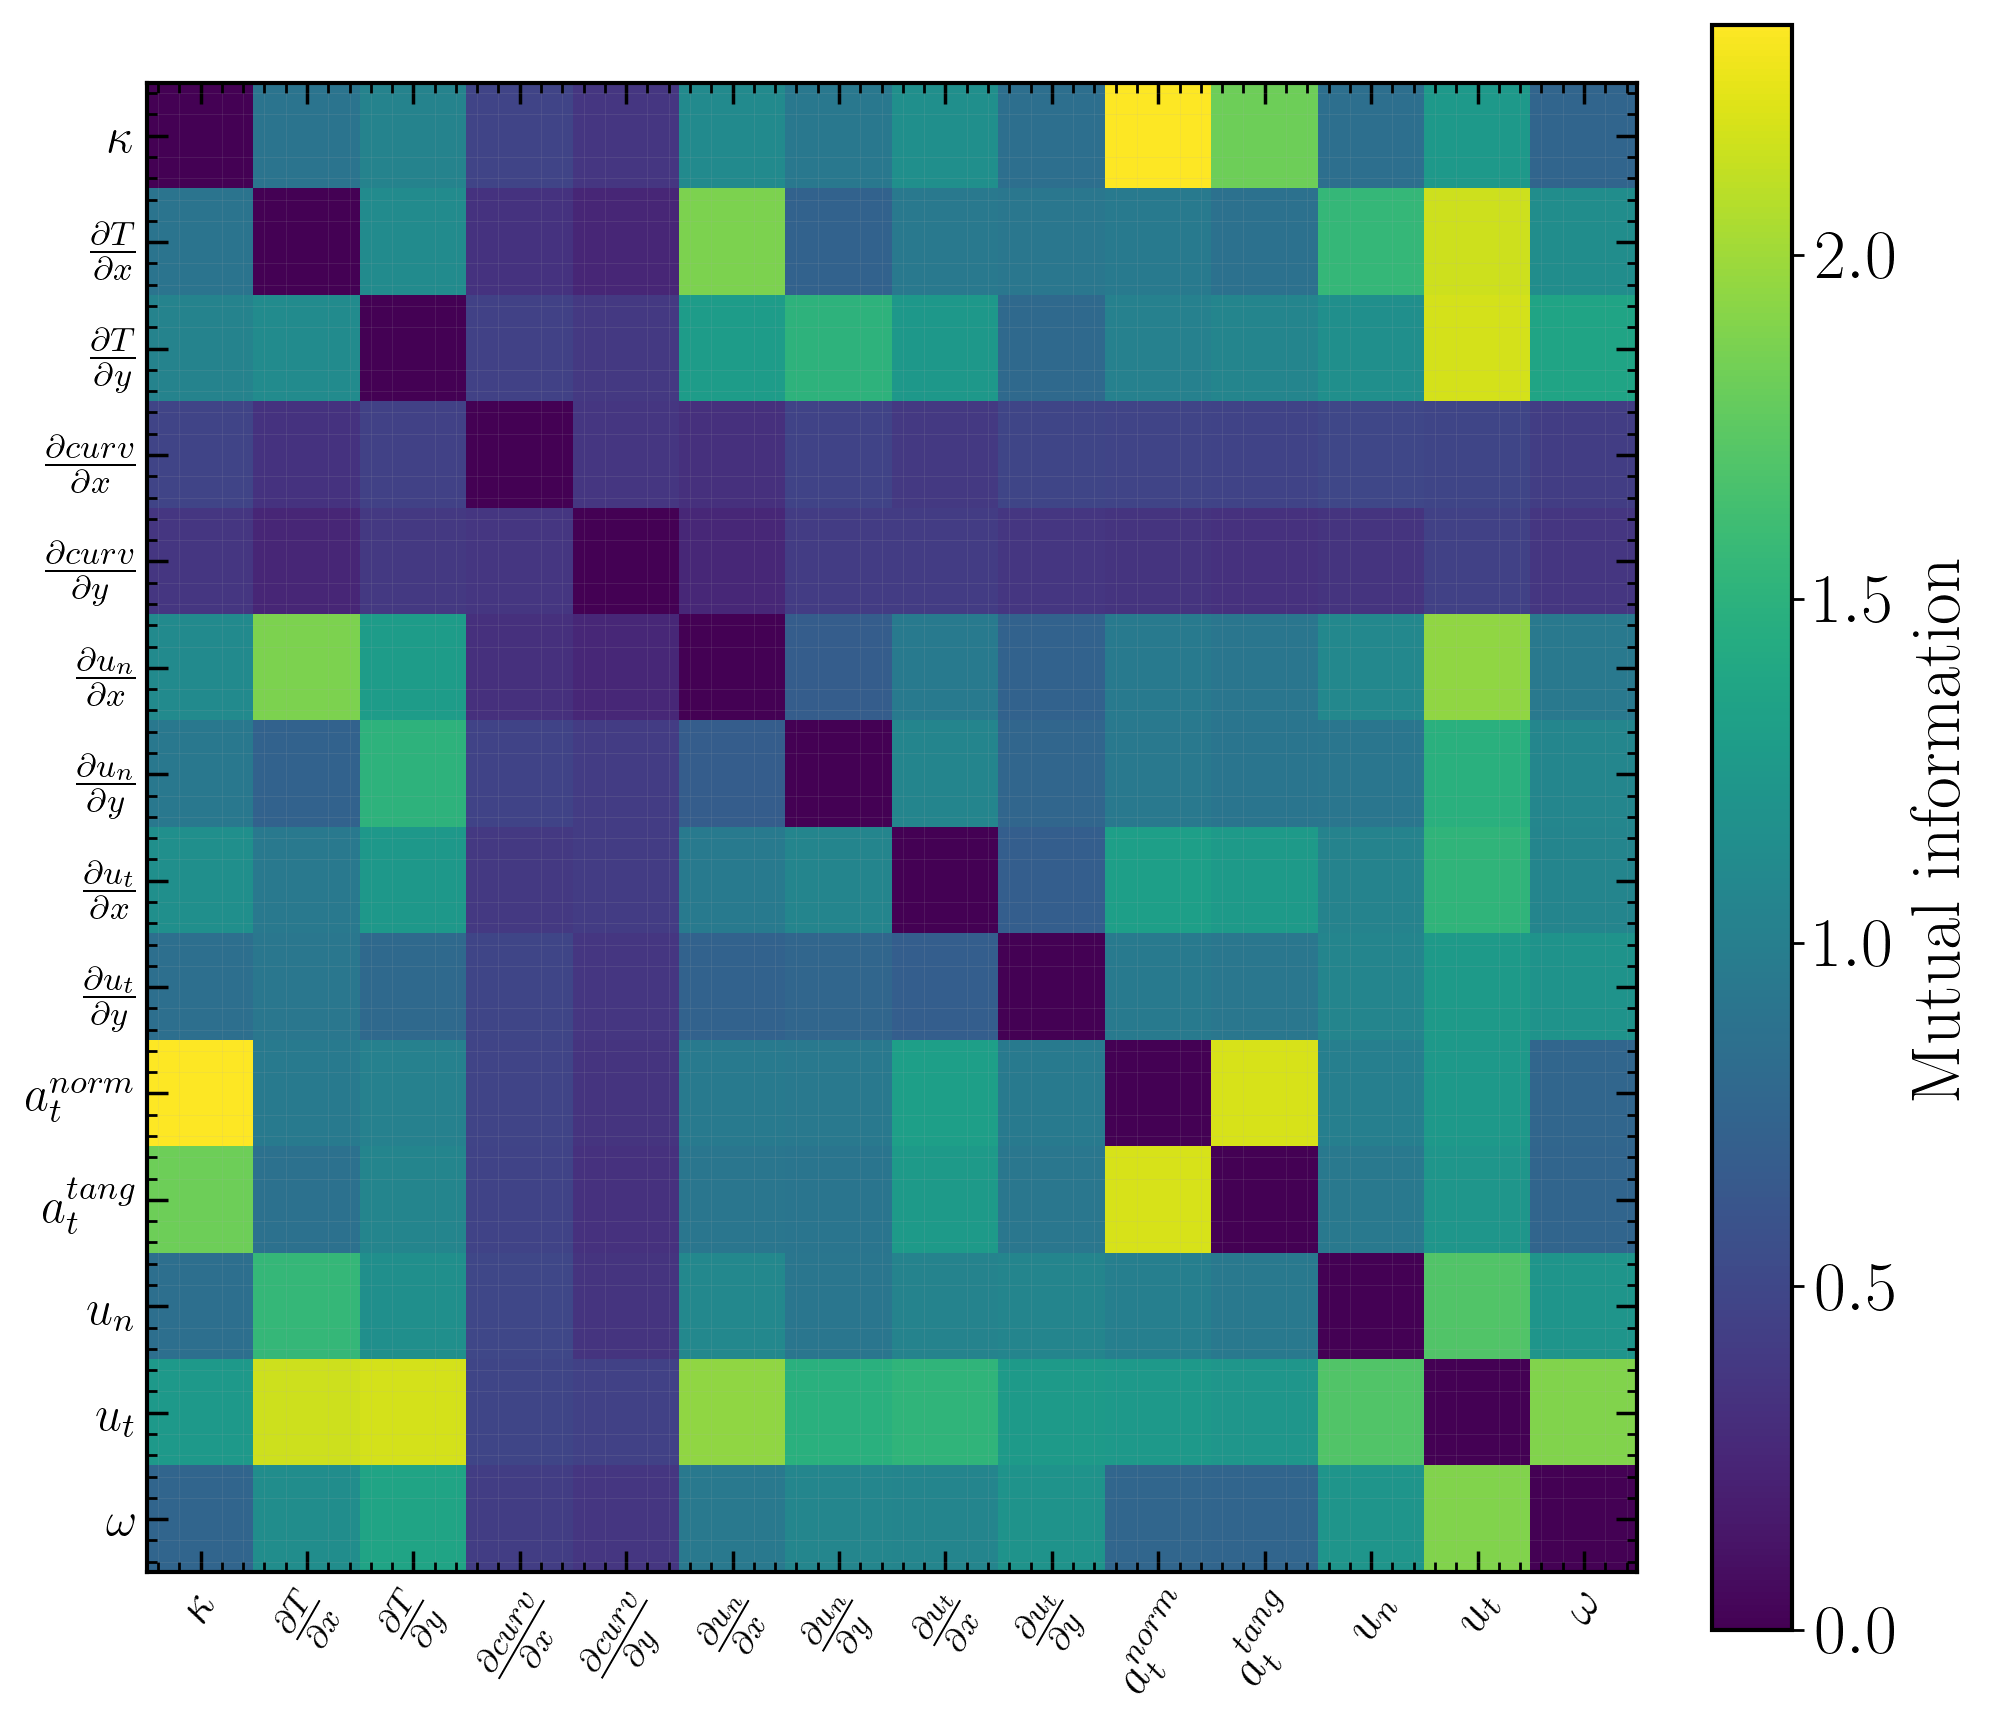

[INFO] MI plot saved: feature_mi_iso0.6_ts198-199-200-201


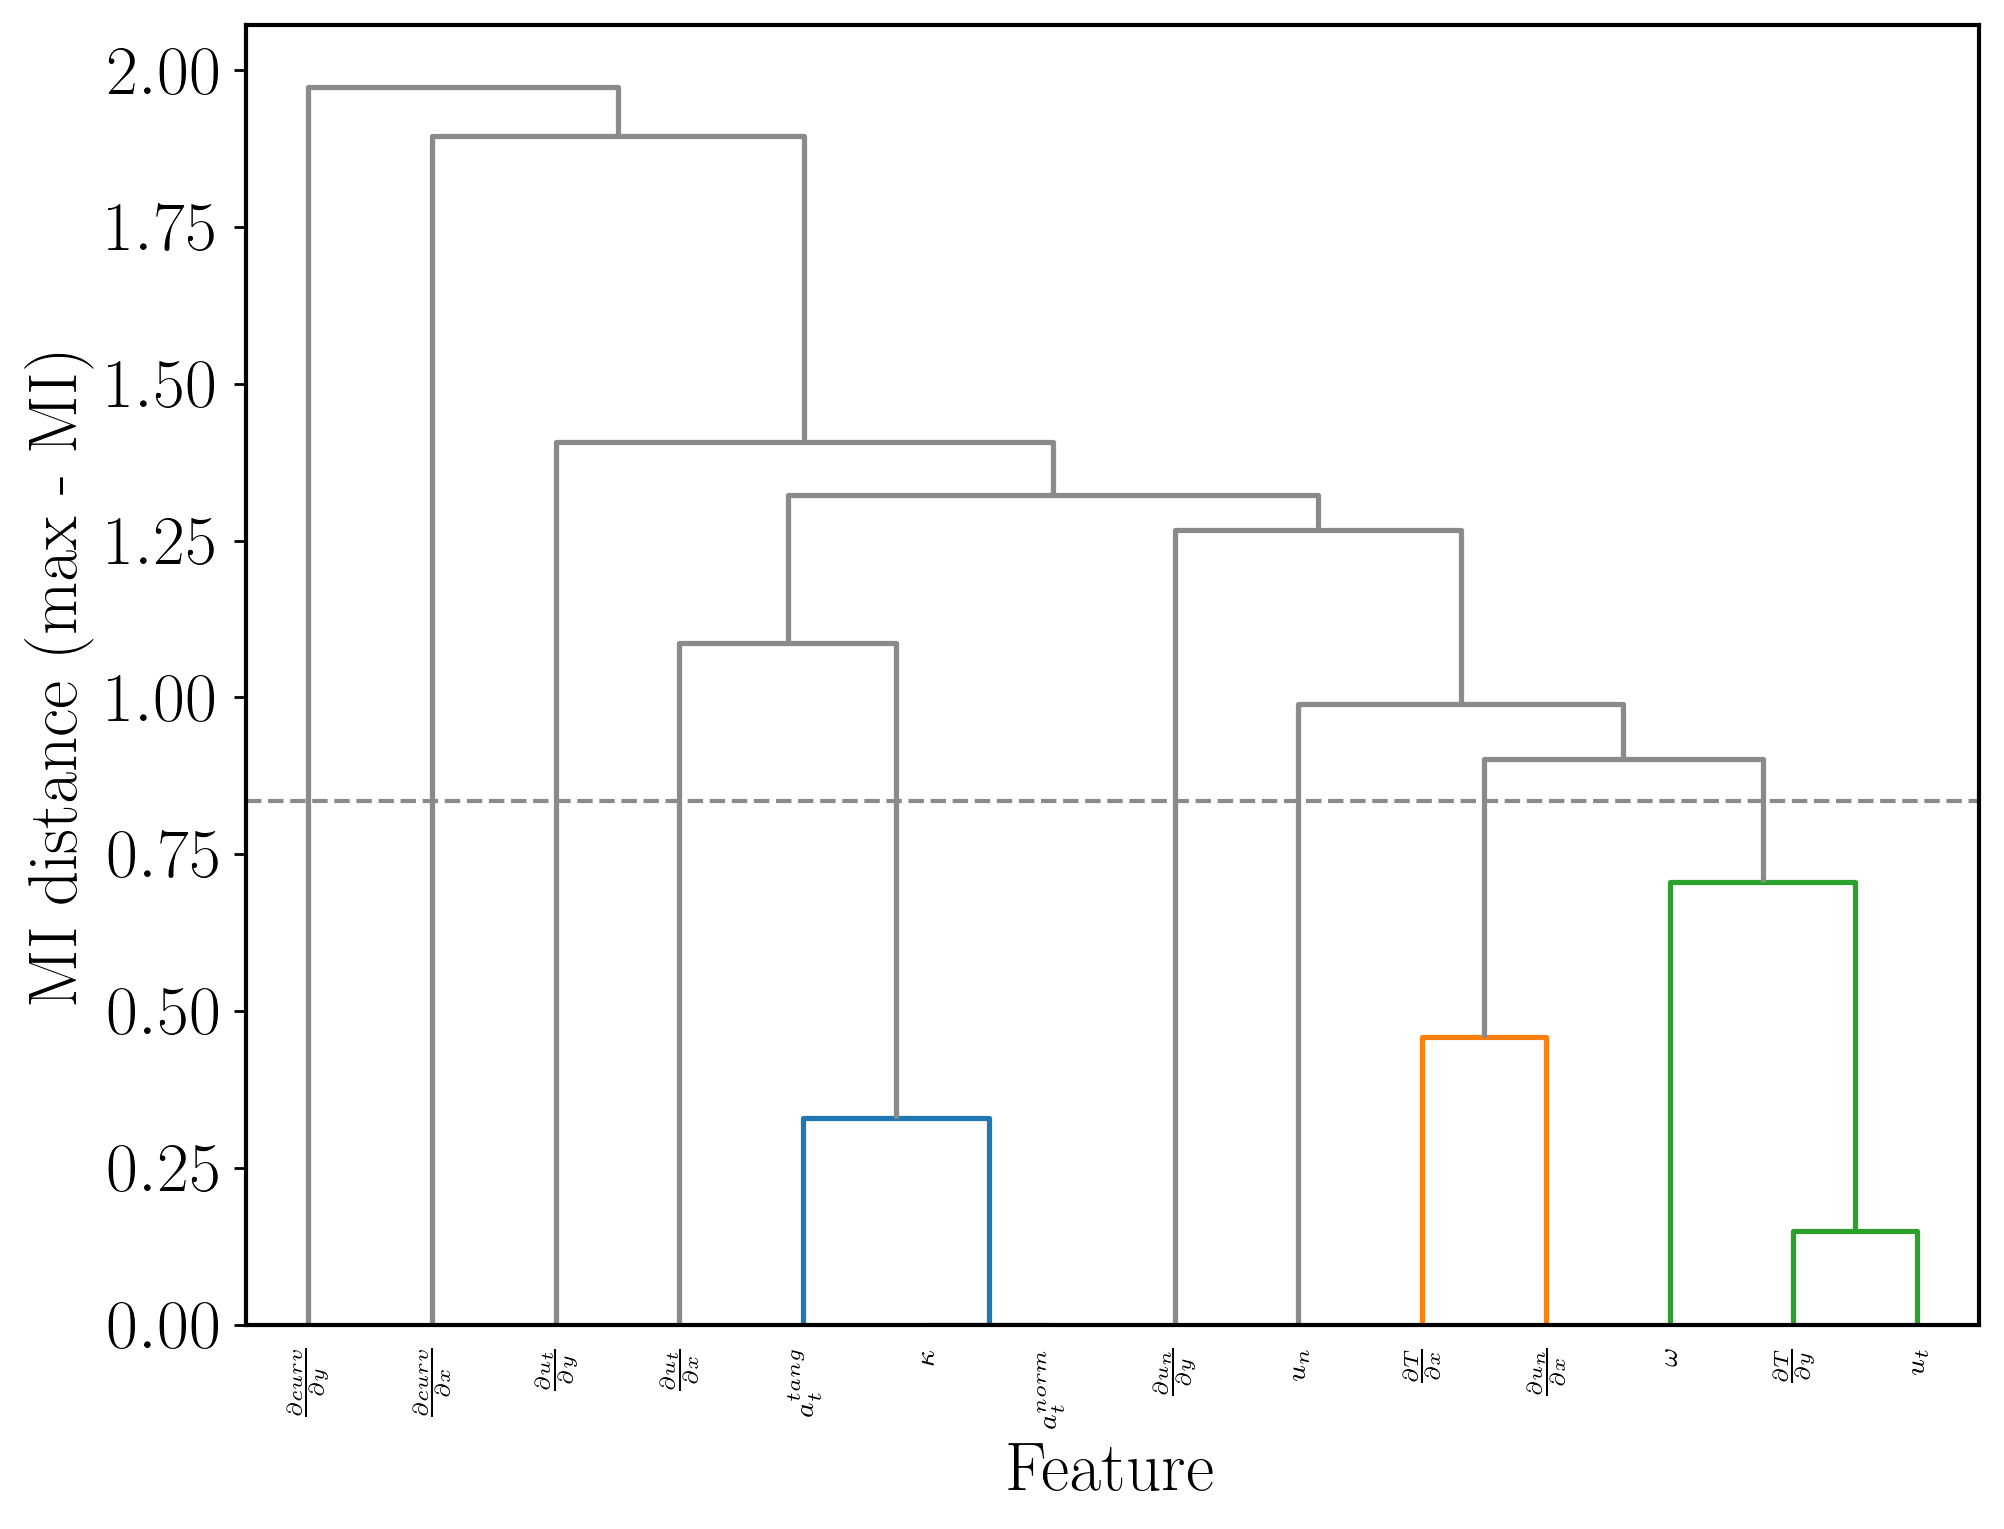

[INFO] MI dendrogram saved: feature_mi_dendrogram_iso0.6_ts198-199-200-201
Representatives (9): ['curvature', 'du_tdx', 'dTdx', 'u_t', 'u_n', 'du_ndy', 'du_tdy', 'dcurvdx', 'dcurvdy']


,mi_cluster,n_features,representative,mi_target,features
0,0,3,curvature,1.156087,"curvature, normal_strain_rate, tangential_stra..."
1,1,1,du_tdx,1.084886,du_tdx
2,2,2,dTdx,1.188775,"dTdx, du_ndx"
3,3,3,u_t,1.808147,"dTdy, u_t, vorticity"
4,4,1,u_n,1.007879,u_n
5,5,1,du_ndy,1.239424,du_ndy
6,6,1,du_tdy,0.708448,du_tdy
7,7,1,dcurvdx,0.503093,dcurvdx
8,8,1,dcurvdy,0.346825,dcurvdy


In [9]:
mi_table = plot_feature_mi_table(
    df=dfc,
    features=list(model_features),
    stem=f"feature_mi_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}",
)
mi_table

mi_clusters: List[List[str]] = []
if mi_table.empty:
    print("[WARN] MI table empty; skipping MI clustering.")
else:
    plot_mi_dendrogram(
        mi=mi_table,
        stem=f"feature_mi_dendrogram_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}",
        threshold=MI_CLUSTER_THRESHOLD,
        linkage_method=MI_CLUSTER_LINKAGE,
    )
    mi_clusters = mi_feature_clusters(
        mi=mi_table,
        threshold=MI_CLUSTER_THRESHOLD,
        linkage=MI_CLUSTER_LINKAGE,
    )

rep_features, rep_info_df, global_mi = select_representative_features(
    df=dfc,
    clusters=mi_clusters,
    target_var=TARGET_VAR,
    random_state=RANDOM_STATE,
)

cluster_map_rows = []
for cl_id, feats in enumerate(mi_clusters):
    for f in feats:
        cluster_map_rows.append({"mi_cluster": cl_id, "feature": f})

cluster_map_df = pd.DataFrame(cluster_map_rows)
if not cluster_map_df.empty:
    (SAVE_DIR / "mi_feature_clusters.csv").write_text(cluster_map_df.to_csv(index=False), encoding="utf-8")

if not rep_info_df.empty:
    rep_info_df.to_csv(SAVE_DIR / "mi_cluster_representatives.csv", index=False)
    print(f"Representatives ({len(rep_features)}): {rep_features}")

rep_info_df


## Curvature binning

Curvature bins: (-0.1, 0.1) -> clusters 0..2


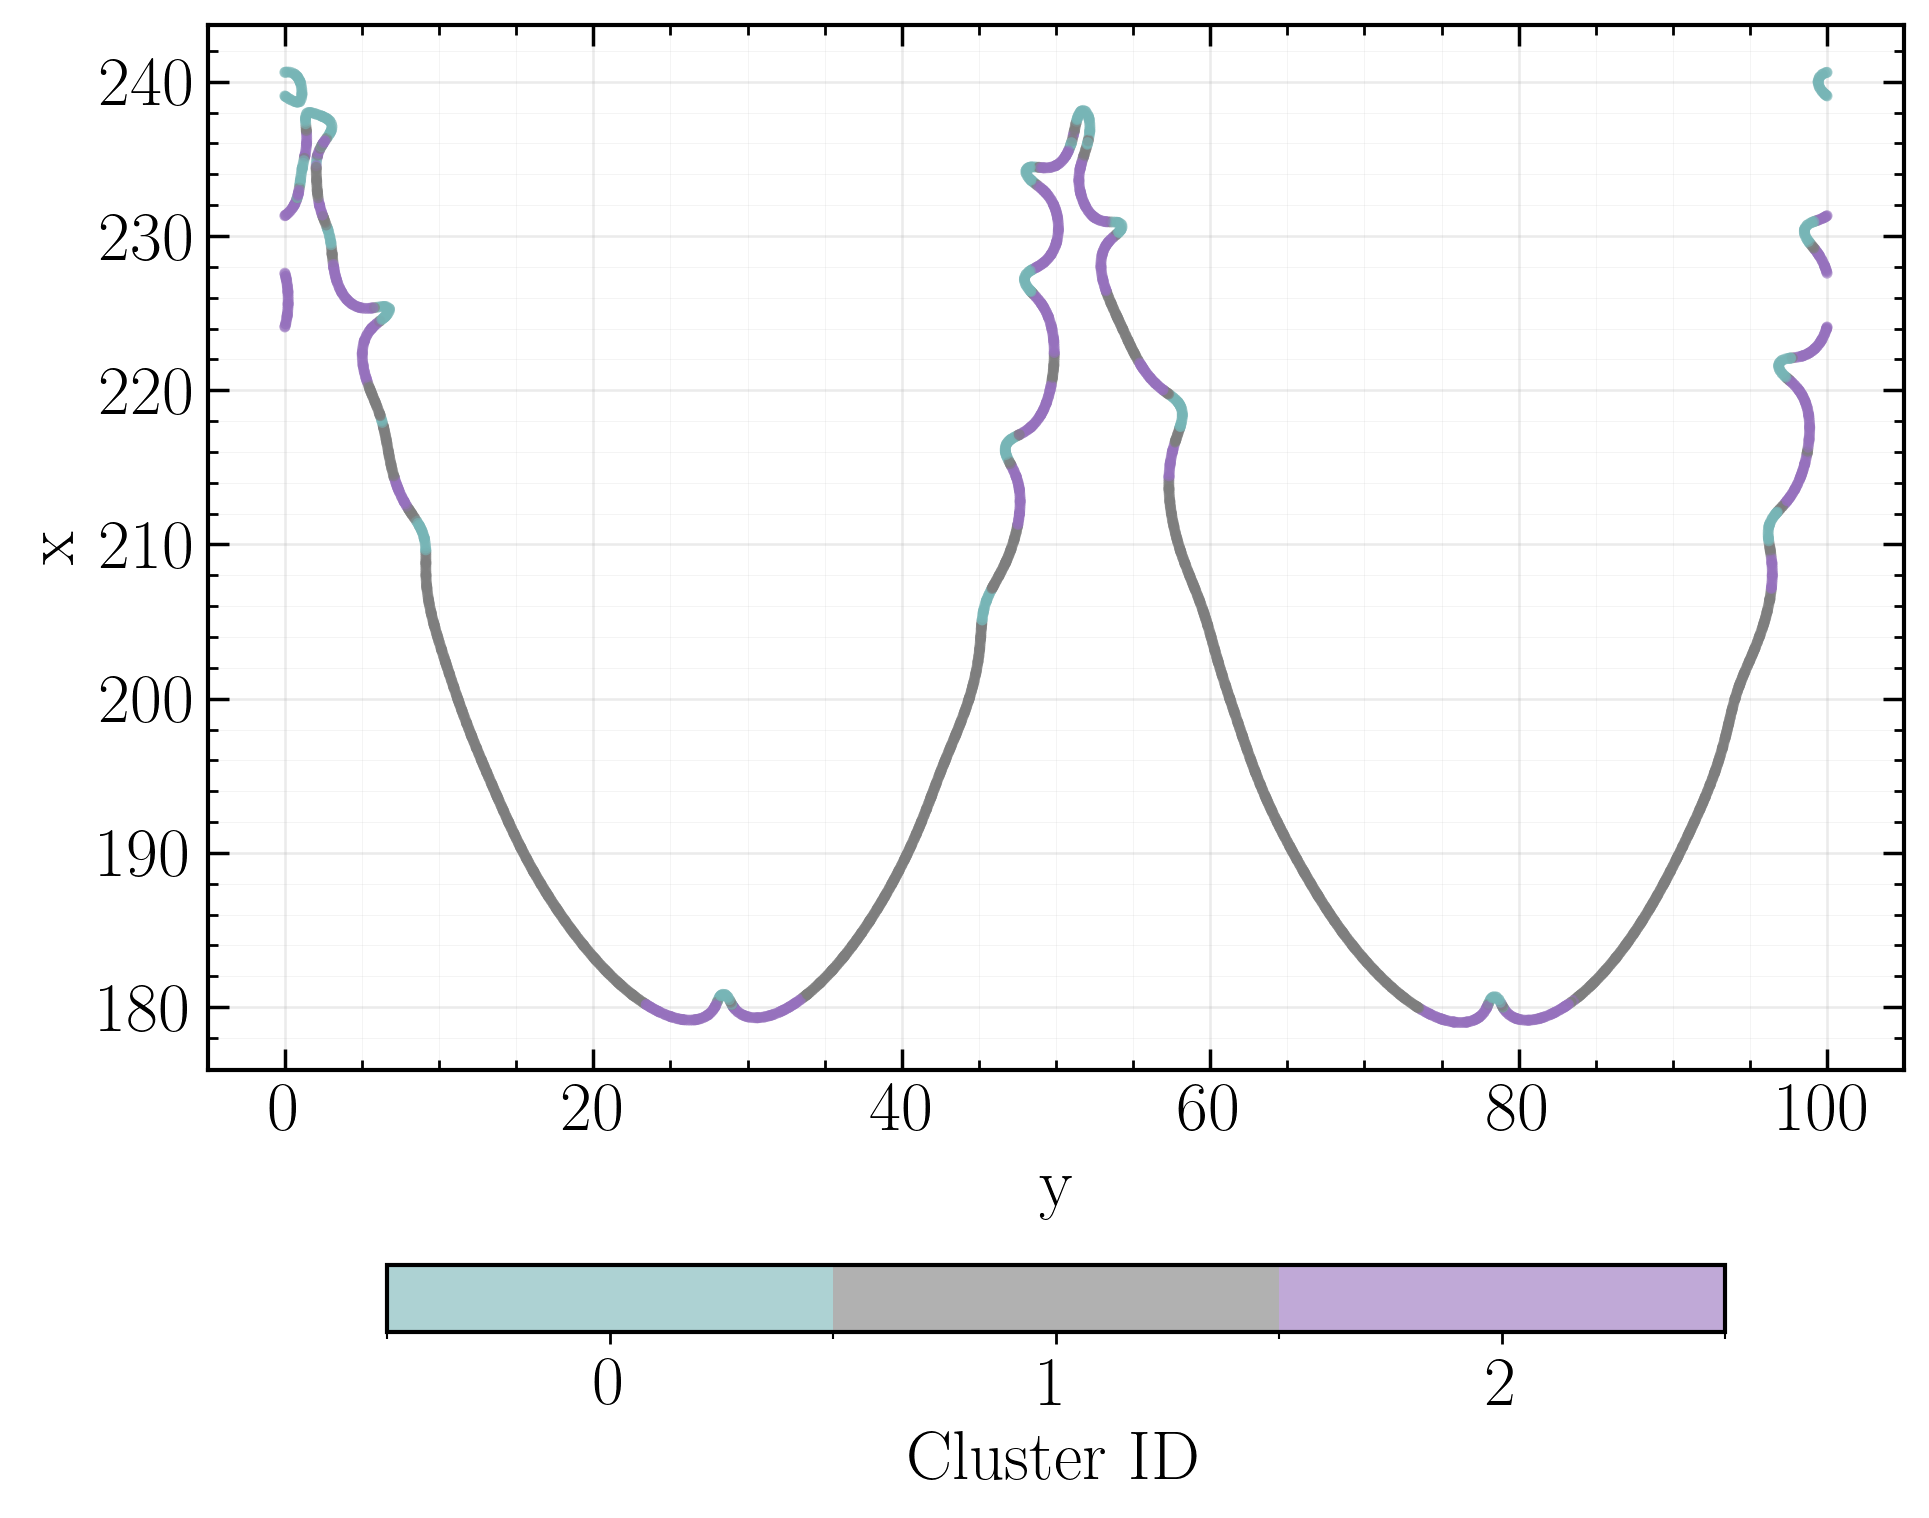

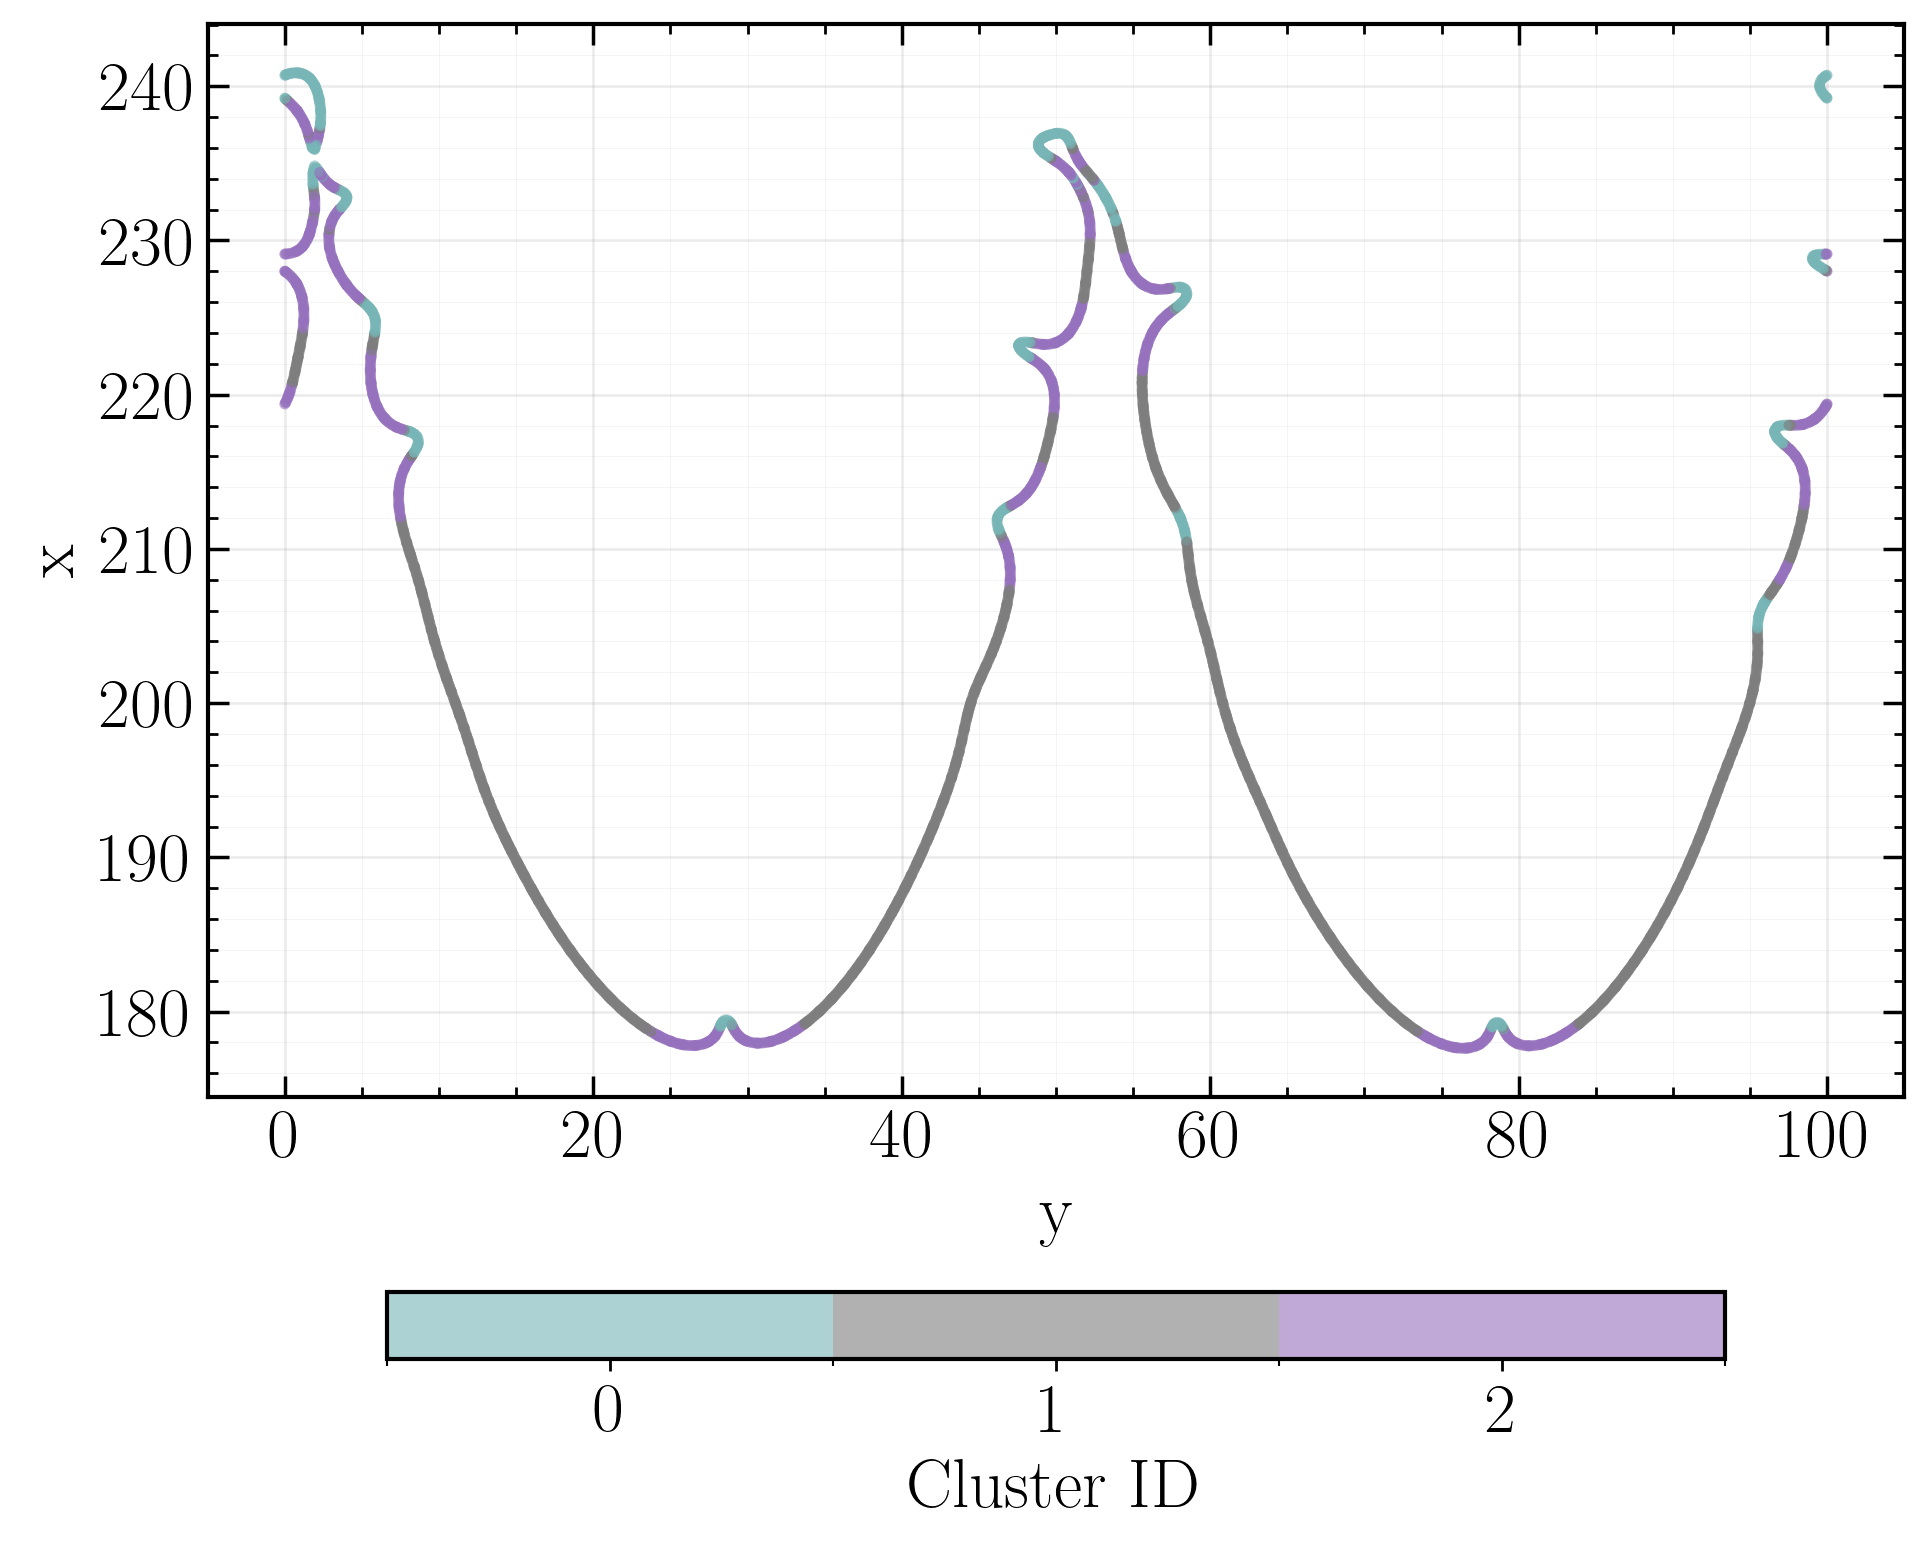

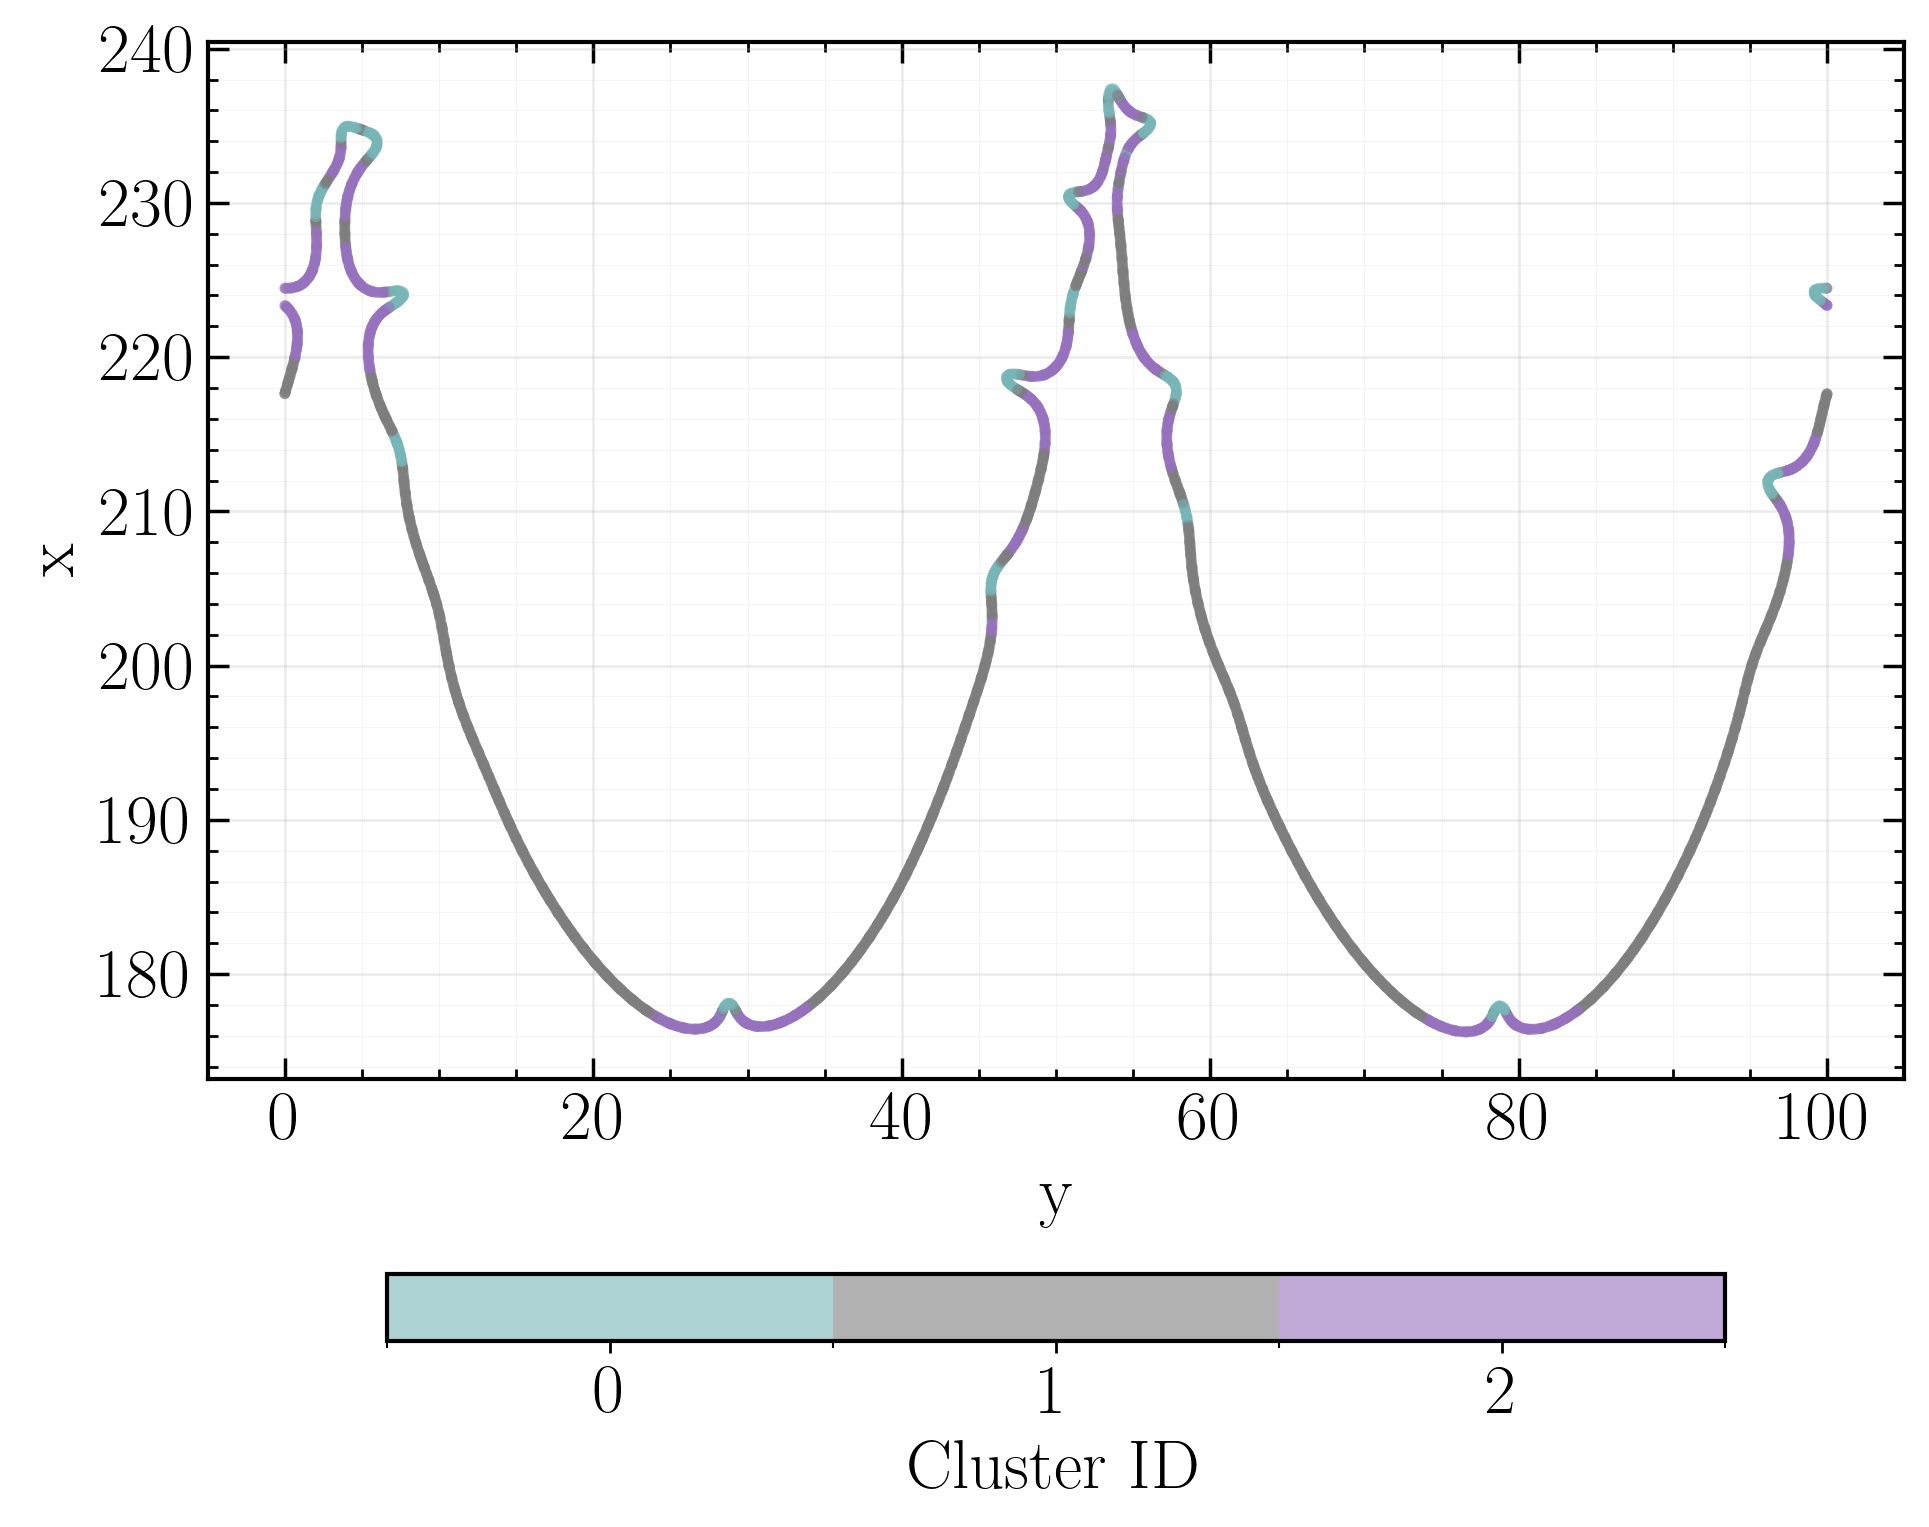

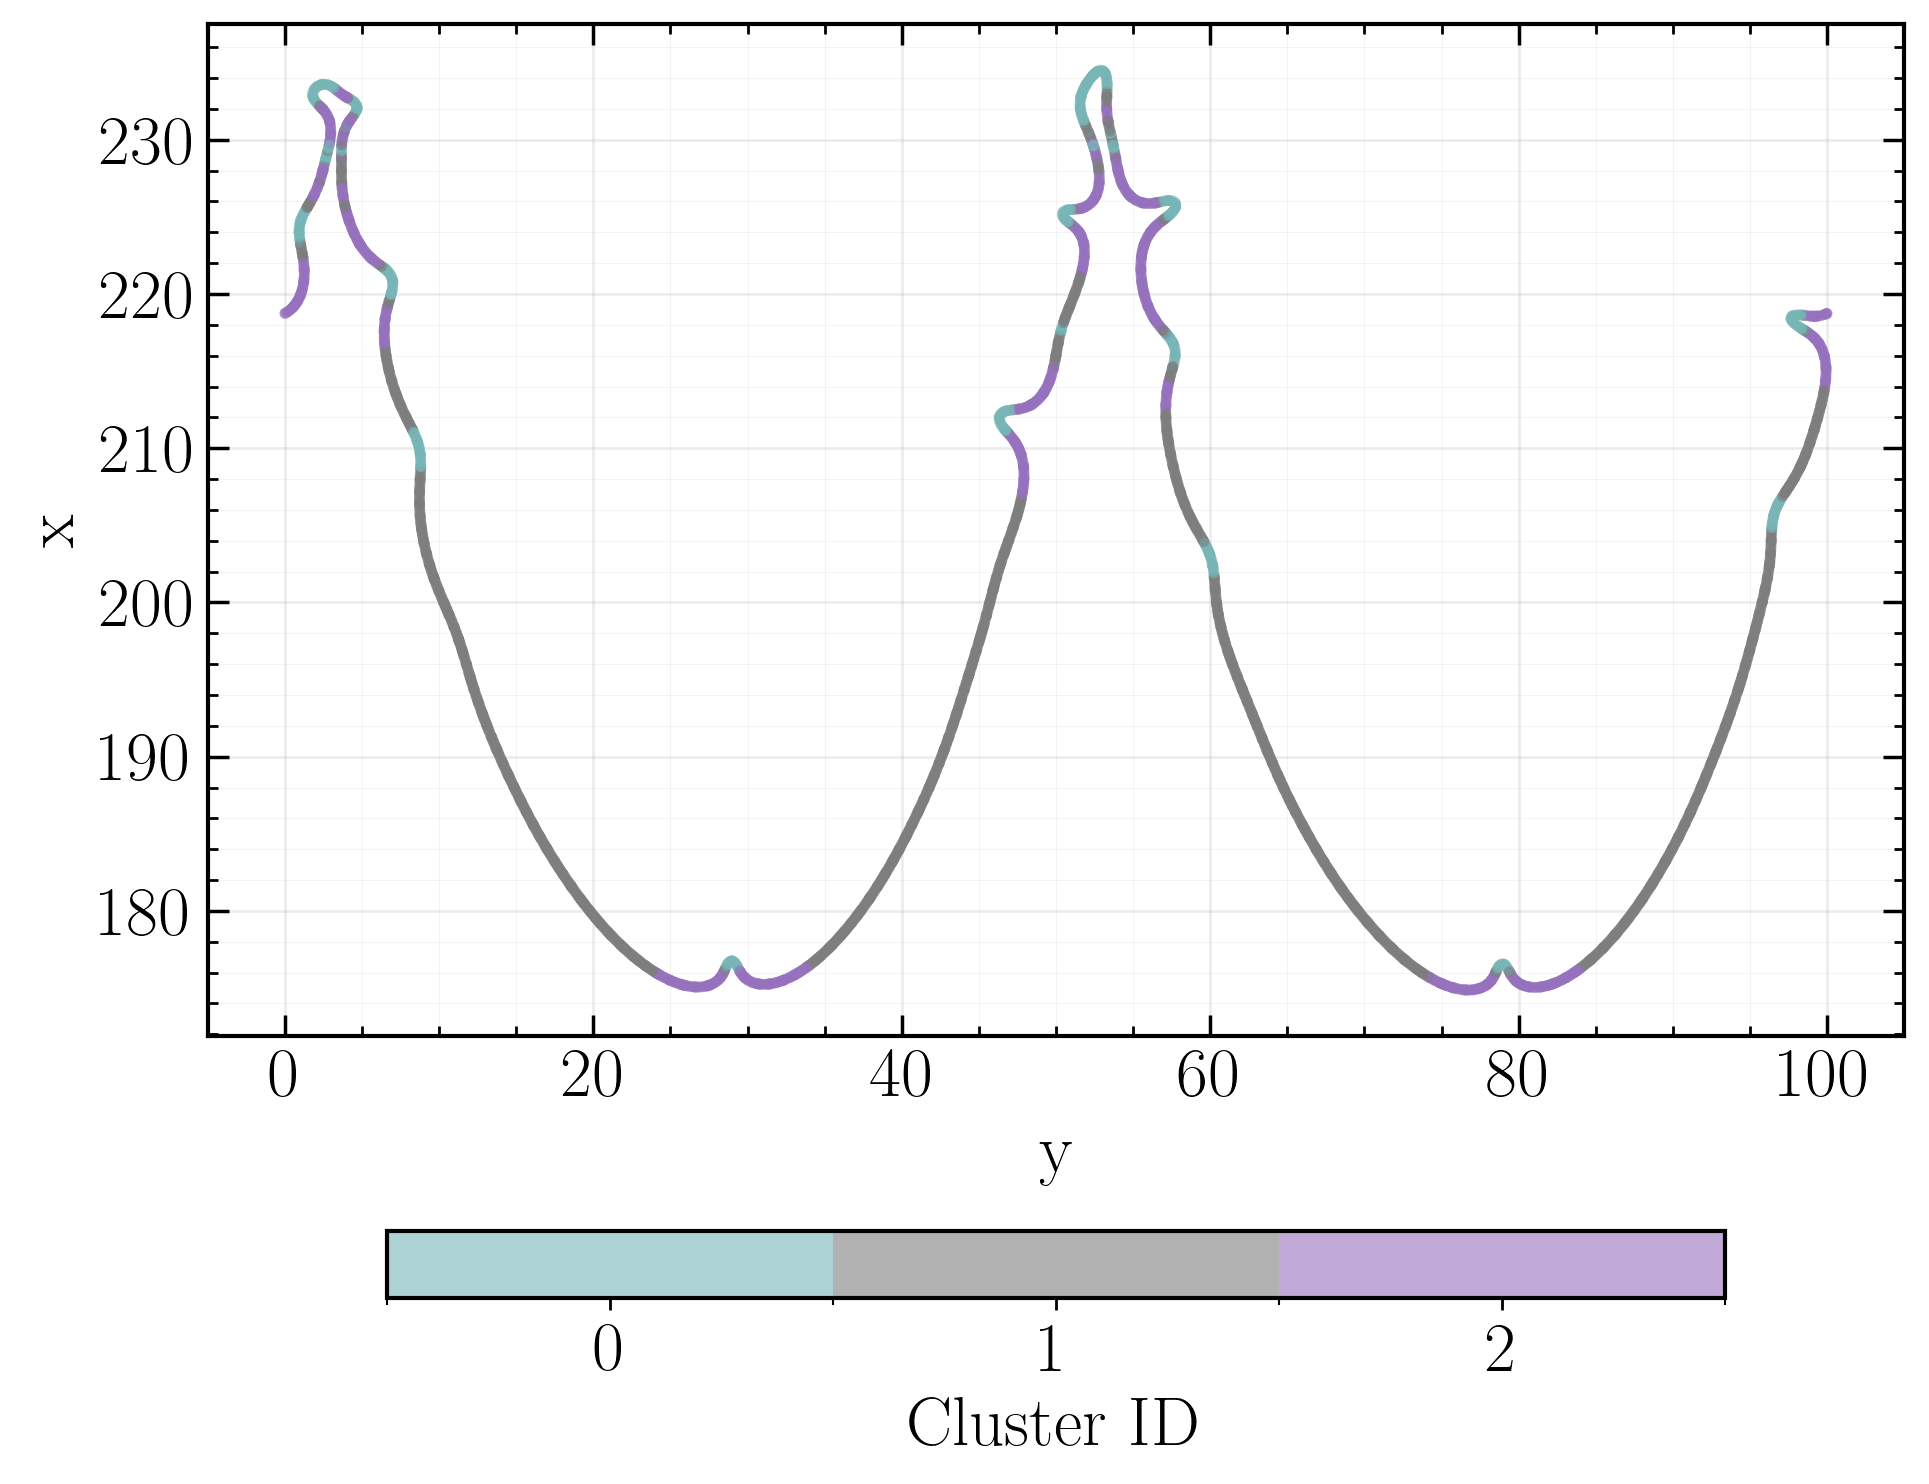

Curvature-bin cluster summary (pooled):
 cluster    n  sd_mean   sd_std
       0 1659 1.093289 0.592640
       1 7678 1.194529 0.118595
       2 3835 1.263492 0.278348


In [10]:
low, high = CURVATURE_BOUNDS
if low >= high:
    raise ValueError("CURVATURE_BOUNDS must be strictly increasing (low < high)")

dfc["cluster"] = np.digitize(dfc[CURVATURE_COLUMN].to_numpy(), bins=[low, high], right=True)
dfc["cluster_conf"] = 1.0

print(f"Curvature bins: {CURVATURE_BOUNDS} -> clusters 0..{N_CLUSTERS - 1}")

for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts].copy()
    if len(sub) == 0:
        continue
    plot_isocontour_scatter(sub, save_stem=f"isocontour_xy_iso{ISOLEVEL}_ts{ts}")

summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
    )
    .reset_index()
    .sort_values("cluster")
)
print("Curvature-bin cluster summary (pooled):")
print(summary_global.to_string(index=False))


## Global feature selection (Backward, JMI, CMIM)

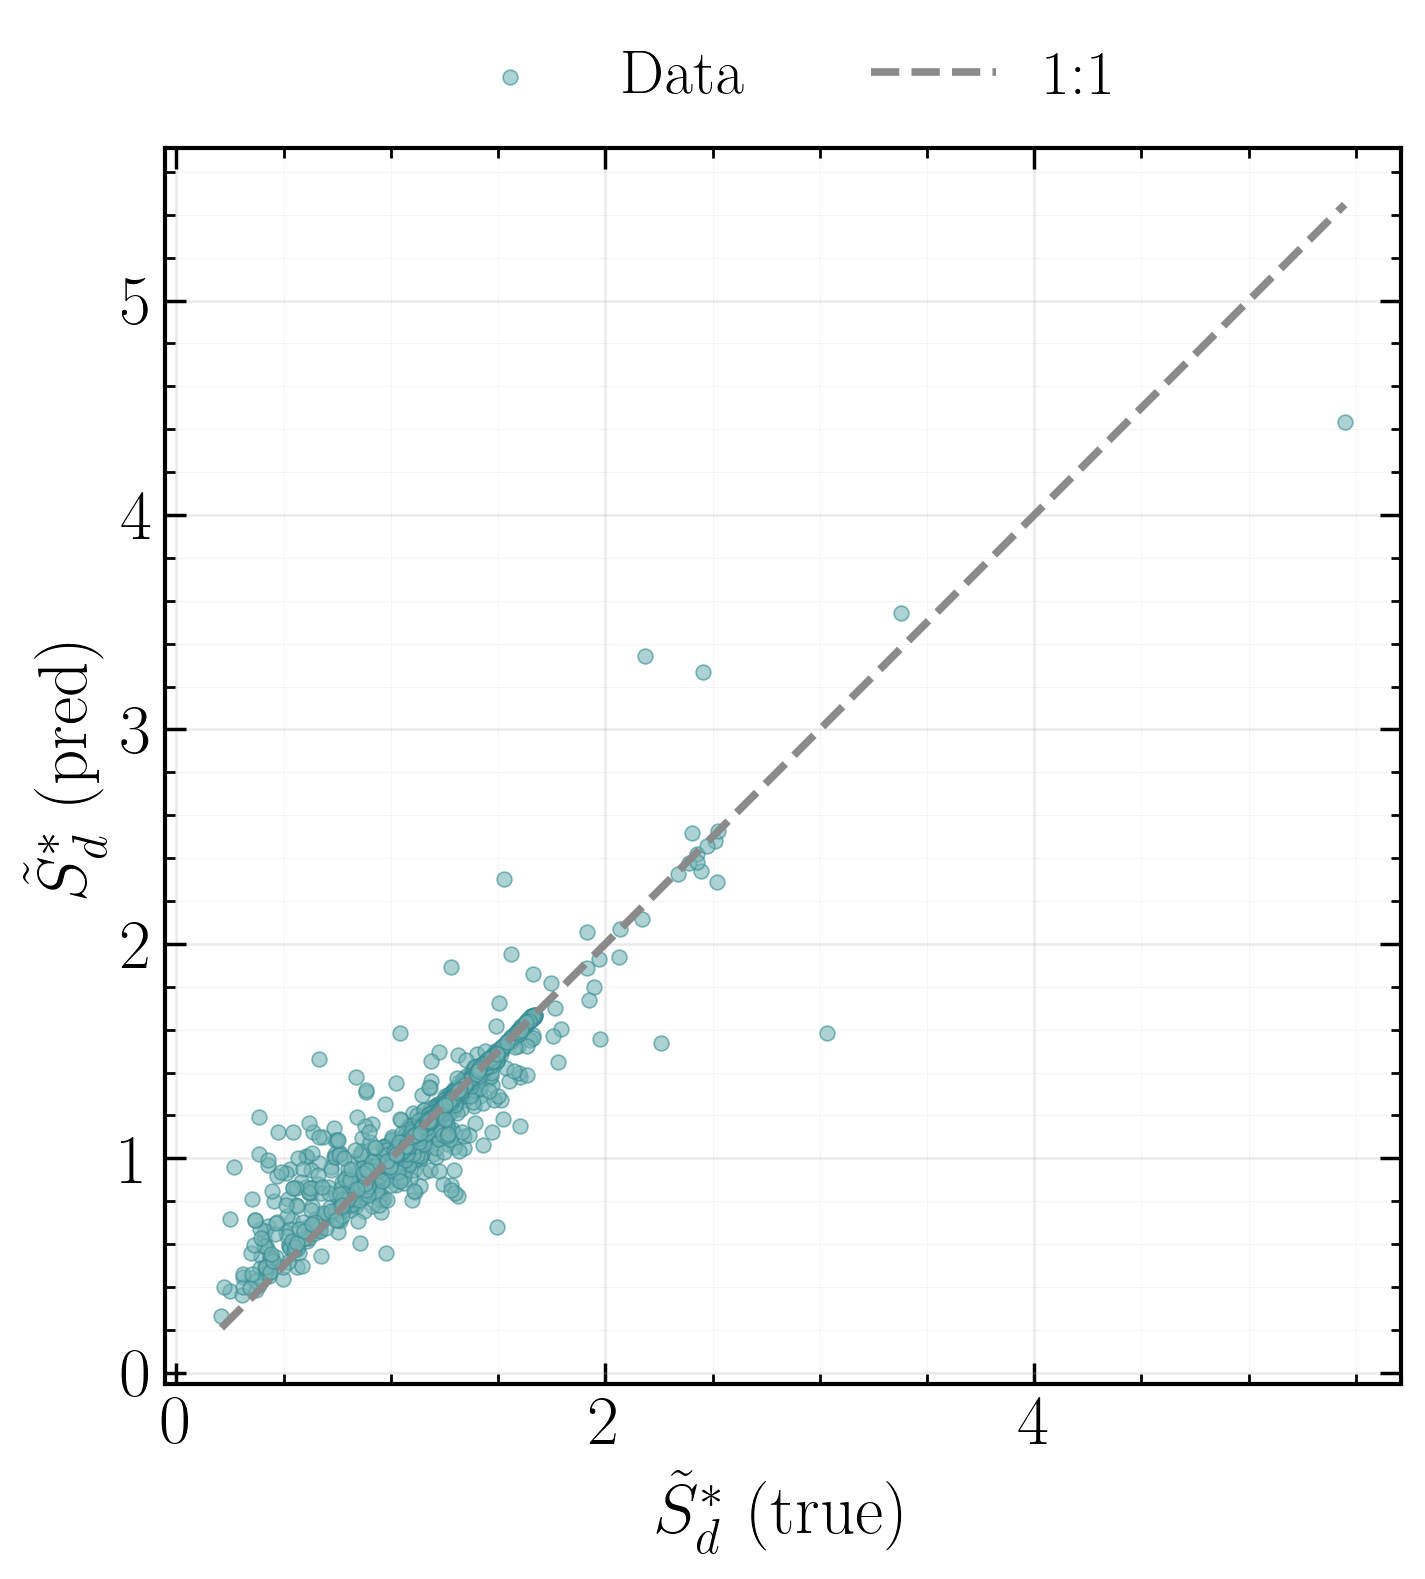

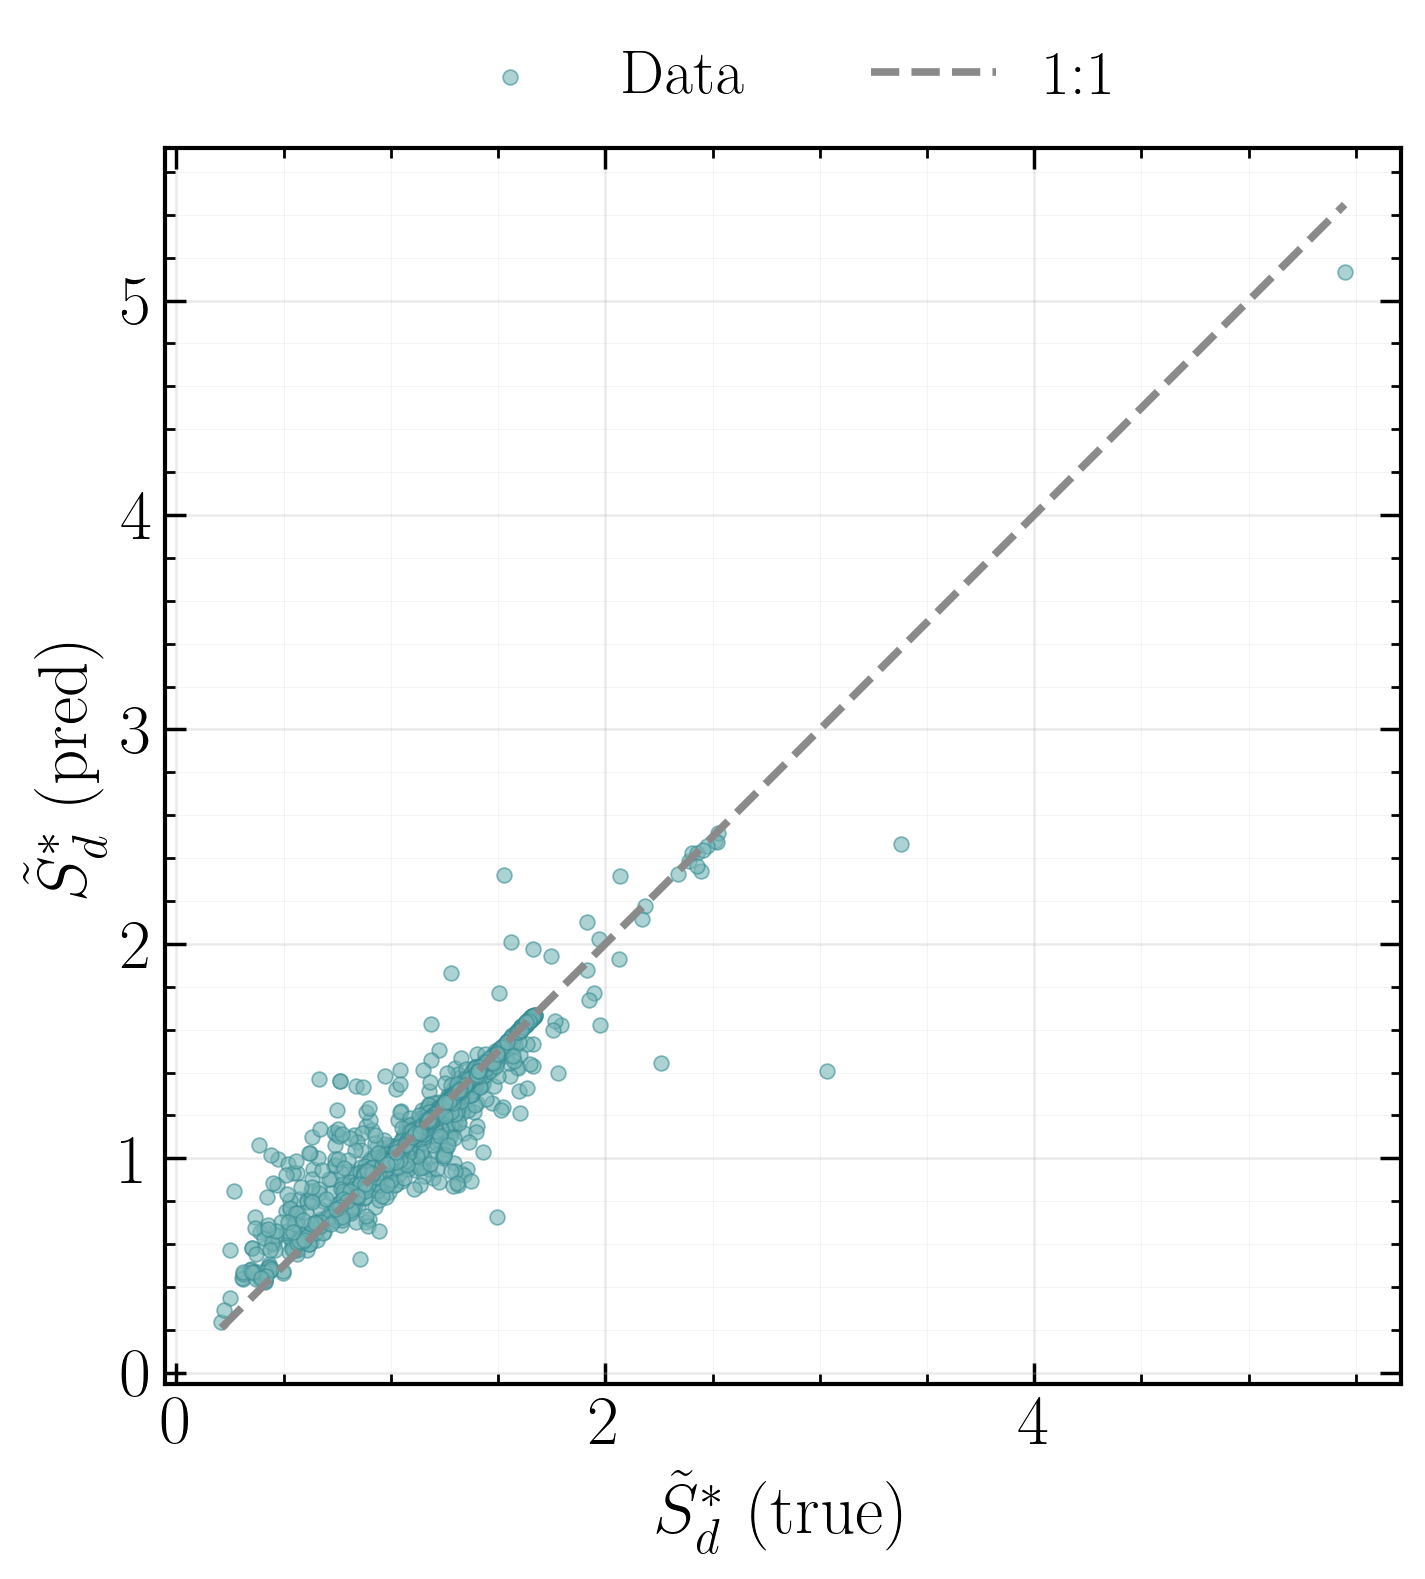

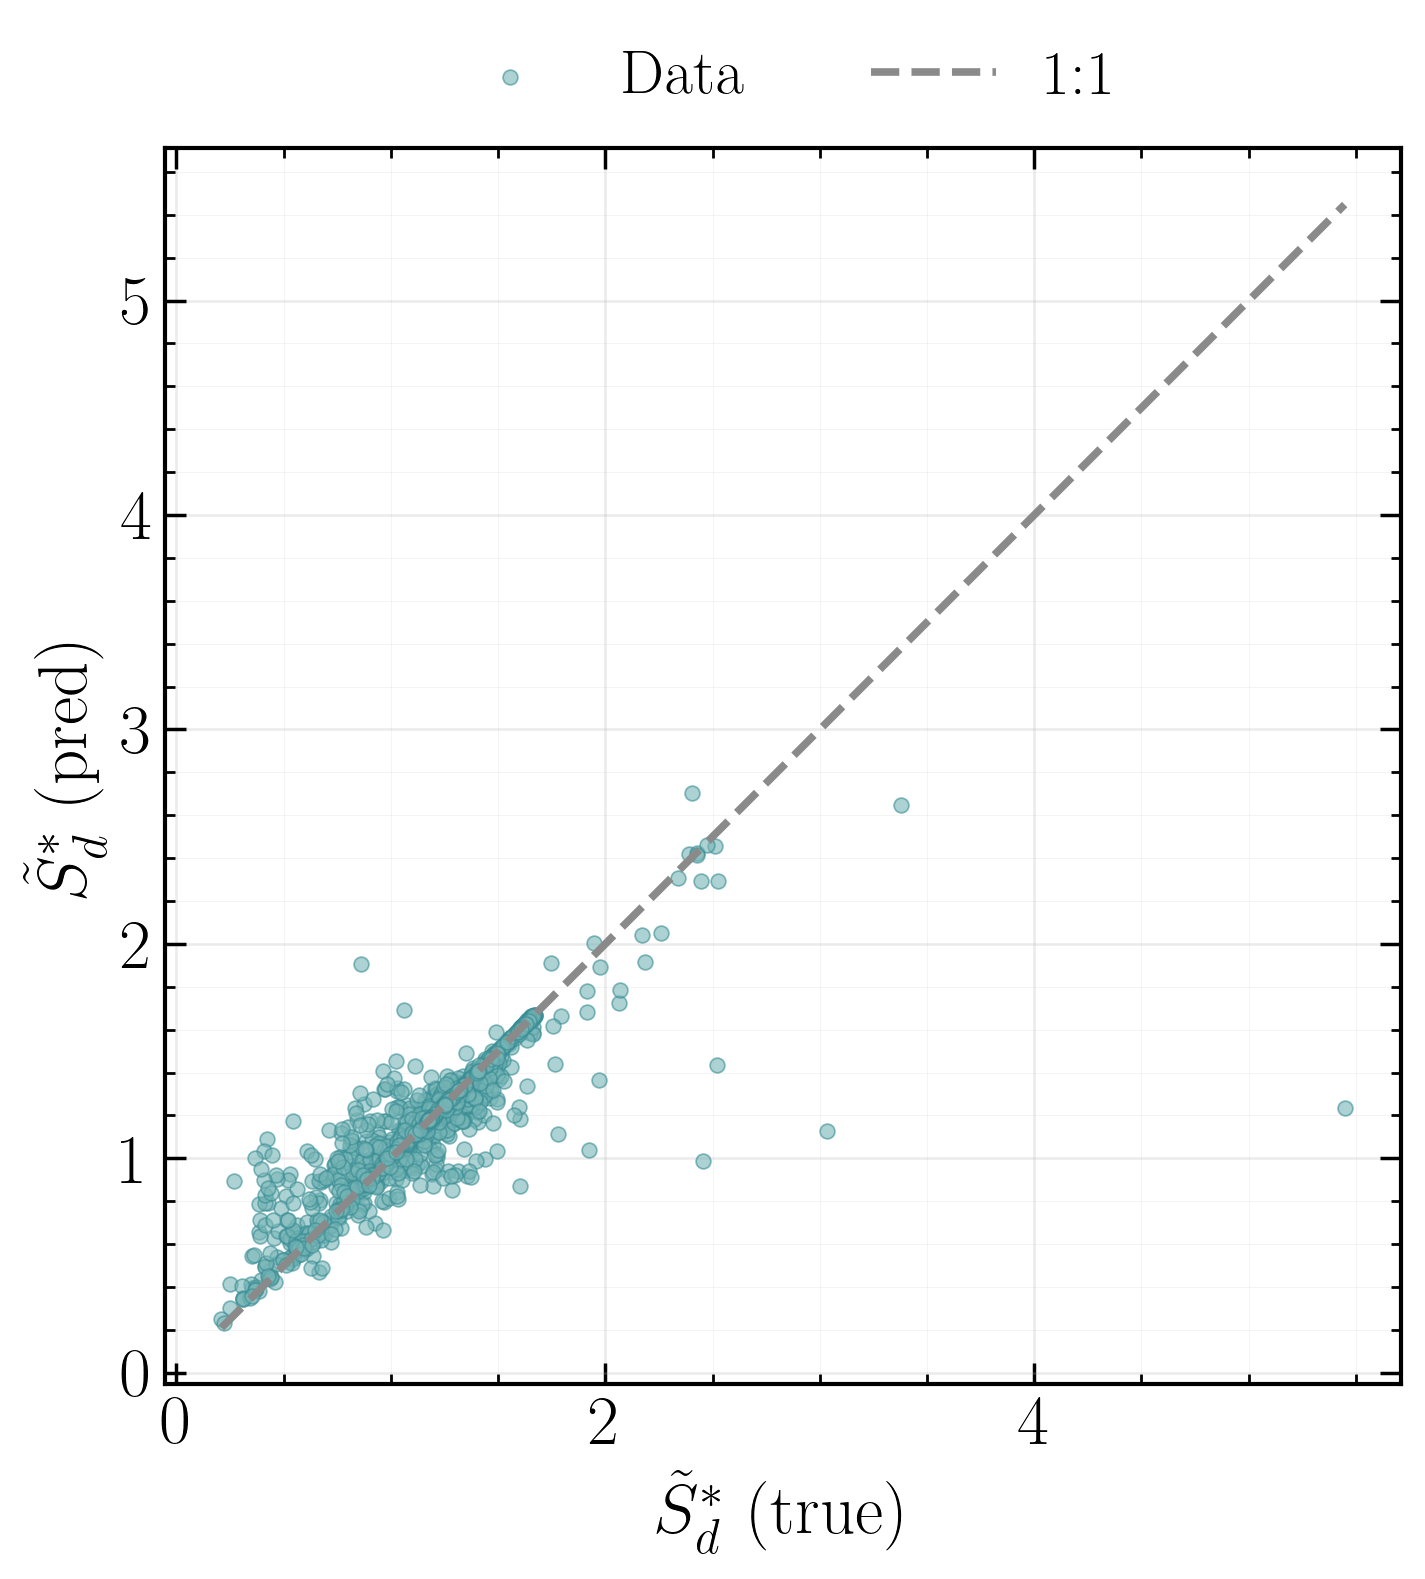


Global selection summary:
 scope   method  n_features                        features       r2     rmse
global Backward           4 curvature, dTdx, du_ndy, du_tdy 0.872752 0.089676
global      JMI           4    u_t, dTdx, du_ndy, curvature 0.882160 0.086298
global     CMIM           4          u_t, dTdx, du_tdx, u_n 0.766501 0.121477

[INFO] Wrote: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/Feature_selection_mi_cluster_jmi_cmim/phi_0.4/h400x100_ref/t_198_to_201/feature_selection_global_summary.csv


In [11]:
rows_global = []

# Helper: get representative set (fallback to full feature set)
rep_features_use = [f for f in rep_features if f in dfc.columns]
if not rep_features_use:
    rep_features_use = list(model_features)

# --- Backward (global) on full feature set ---
X_all = dfc[rep_features_use].to_numpy()
y_all = dfc[TARGET_VAR].to_numpy()

bw_global = run_backward_selection(
    X=X_all,
    y=y_all,
    feature_names=rep_features_use,
    n_features_to_select=BACKWARD_N_FEATURES_GLOBAL,
    random_state=RANDOM_STATE,
    scoring=SFS_SCORING,
    cv_splits=SFS_CV_SPLITS,
)

if bw_global:
    r2, rmse, yte, ypred = evaluate_model_rf(dfc[bw_global].to_numpy(), y_all, TEST_SIZE, RANDOM_STATE)
    plot_pred_vs_true(
        yte,
        ypred,
        title=f"Backward (global) | top-{len(bw_global)}",
        save_stem=f"pred_vs_true_backward_global_top{len(bw_global)}",
    )
    rows_global.append({
        "scope": "global",
        "method": "Backward",
        "n_features": len(bw_global),
        "features": ", ".join(bw_global),
        "r2": r2,
        "rmse": rmse,
    })

# --- JMI/CMIM (global) on representatives ---
jmi_global, _ = select_jmi_features(dfc, TARGET_VAR, rep_features_use, K_SELECT_GLOBAL, RANDOM_STATE)
cmim_global, _ = select_cmim_features(dfc, TARGET_VAR, rep_features_use, K_SELECT_GLOBAL, RANDOM_STATE)

for method, feats in [("JMI", jmi_global), ("CMIM", cmim_global)]:
    if not feats:
        continue
    r2, rmse, yte, ypred = evaluate_model_rf(dfc[feats].to_numpy(), y_all, TEST_SIZE, RANDOM_STATE)
    plot_pred_vs_true(
        yte,
        ypred,
        title=f"{method} (global) | top-{len(feats)}",
        save_stem=f"pred_vs_true_{method.lower()}_global_top{len(feats)}",
    )
    rows_global.append({
        "scope": "global",
        "method": method,
        "n_features": len(feats),
        "features": ", ".join(feats),
        "r2": r2,
        "rmse": rmse,
    })

# --- Save global summary ---
if rows_global:
    global_df = pd.DataFrame(rows_global)
    global_csv = SAVE_DIR / "feature_selection_global_summary.csv"
    global_df.to_csv(global_csv, index=False)
    print()
    print("Global selection summary:")
    print(global_df.to_string(index=False))
    print()
    print(f"[INFO] Wrote: {global_csv}")
else:
    print("[WARN] No global selection results.")


## Per-curvature-cluster feature selection (Backward, JMI, CMIM)


--- Curvature cluster 0 | n=1659 ---


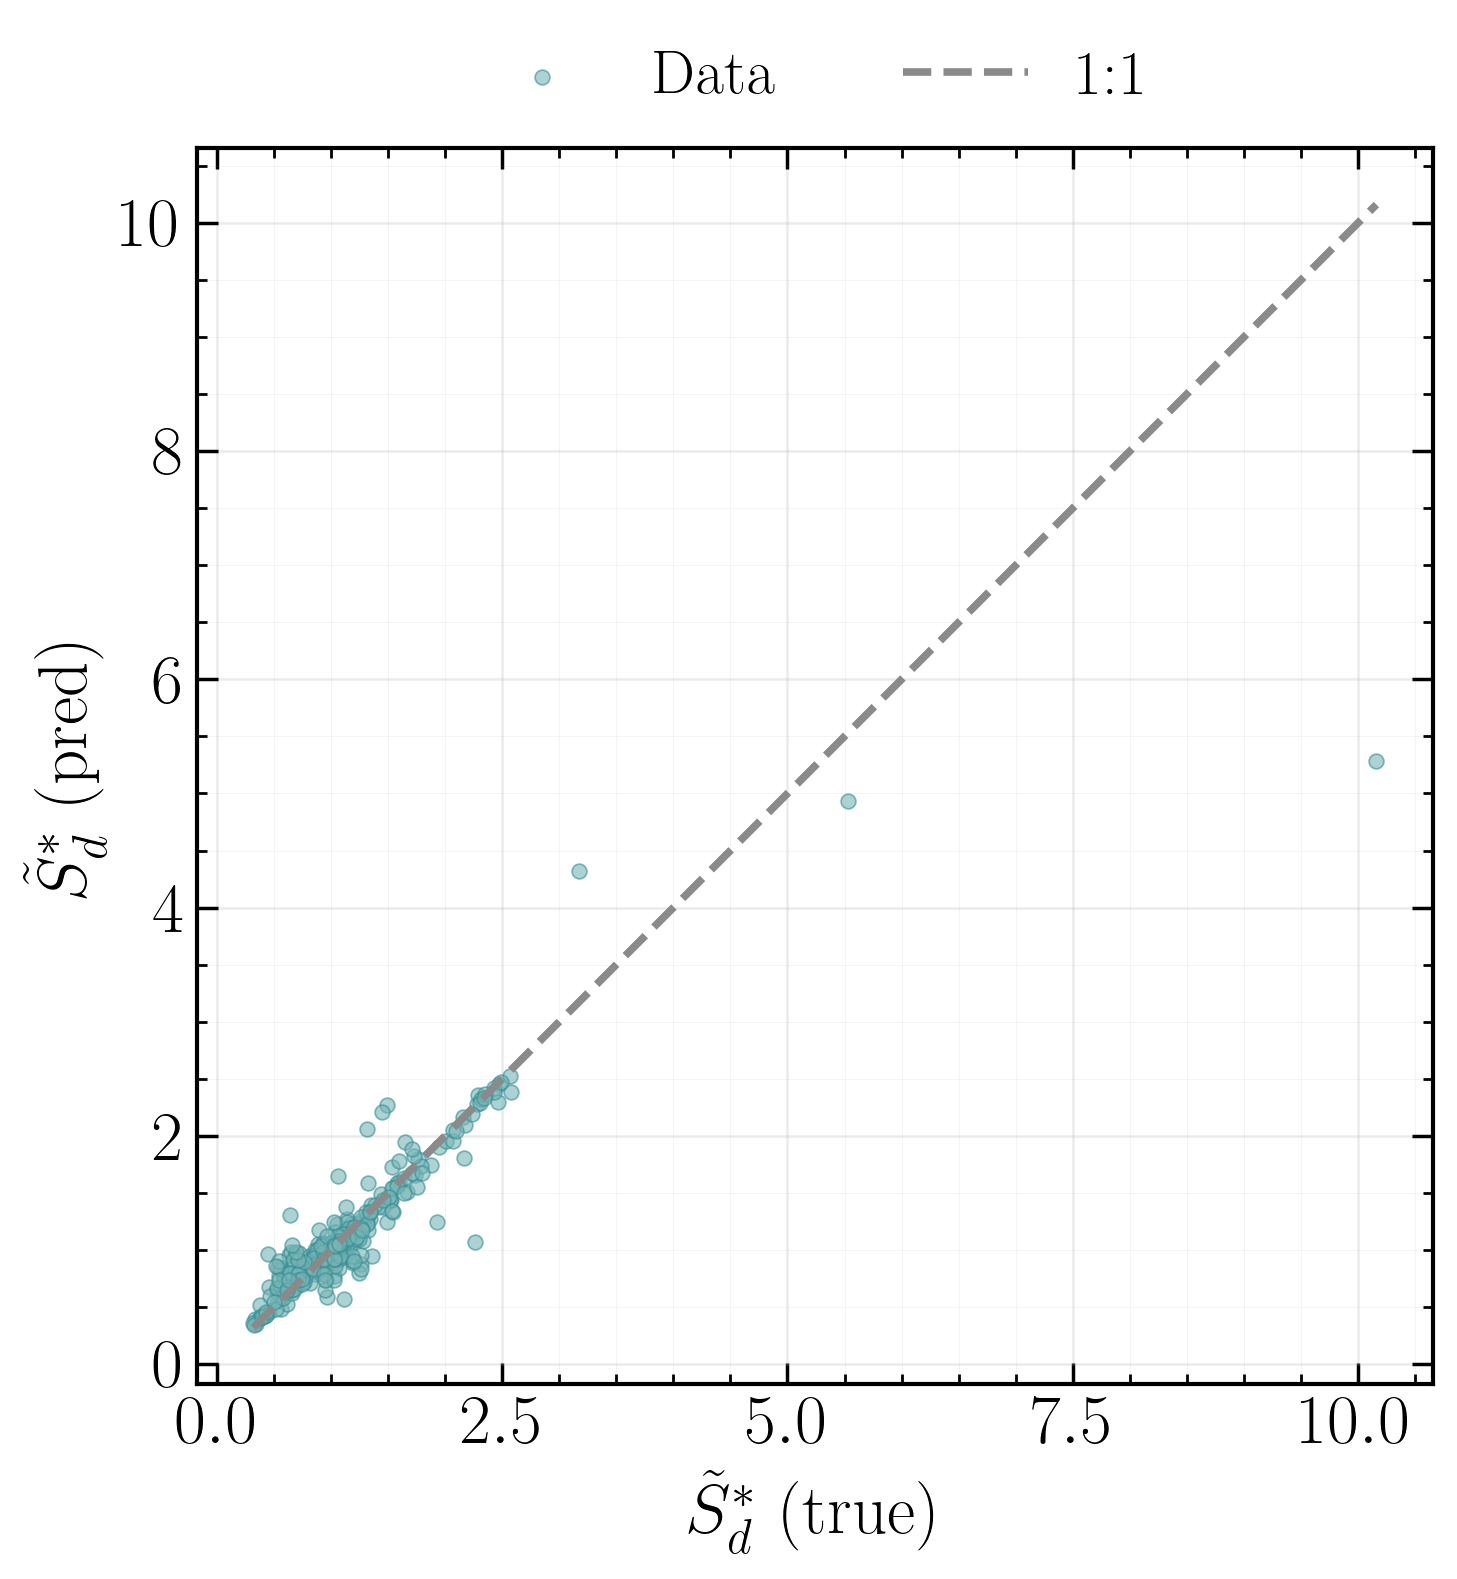

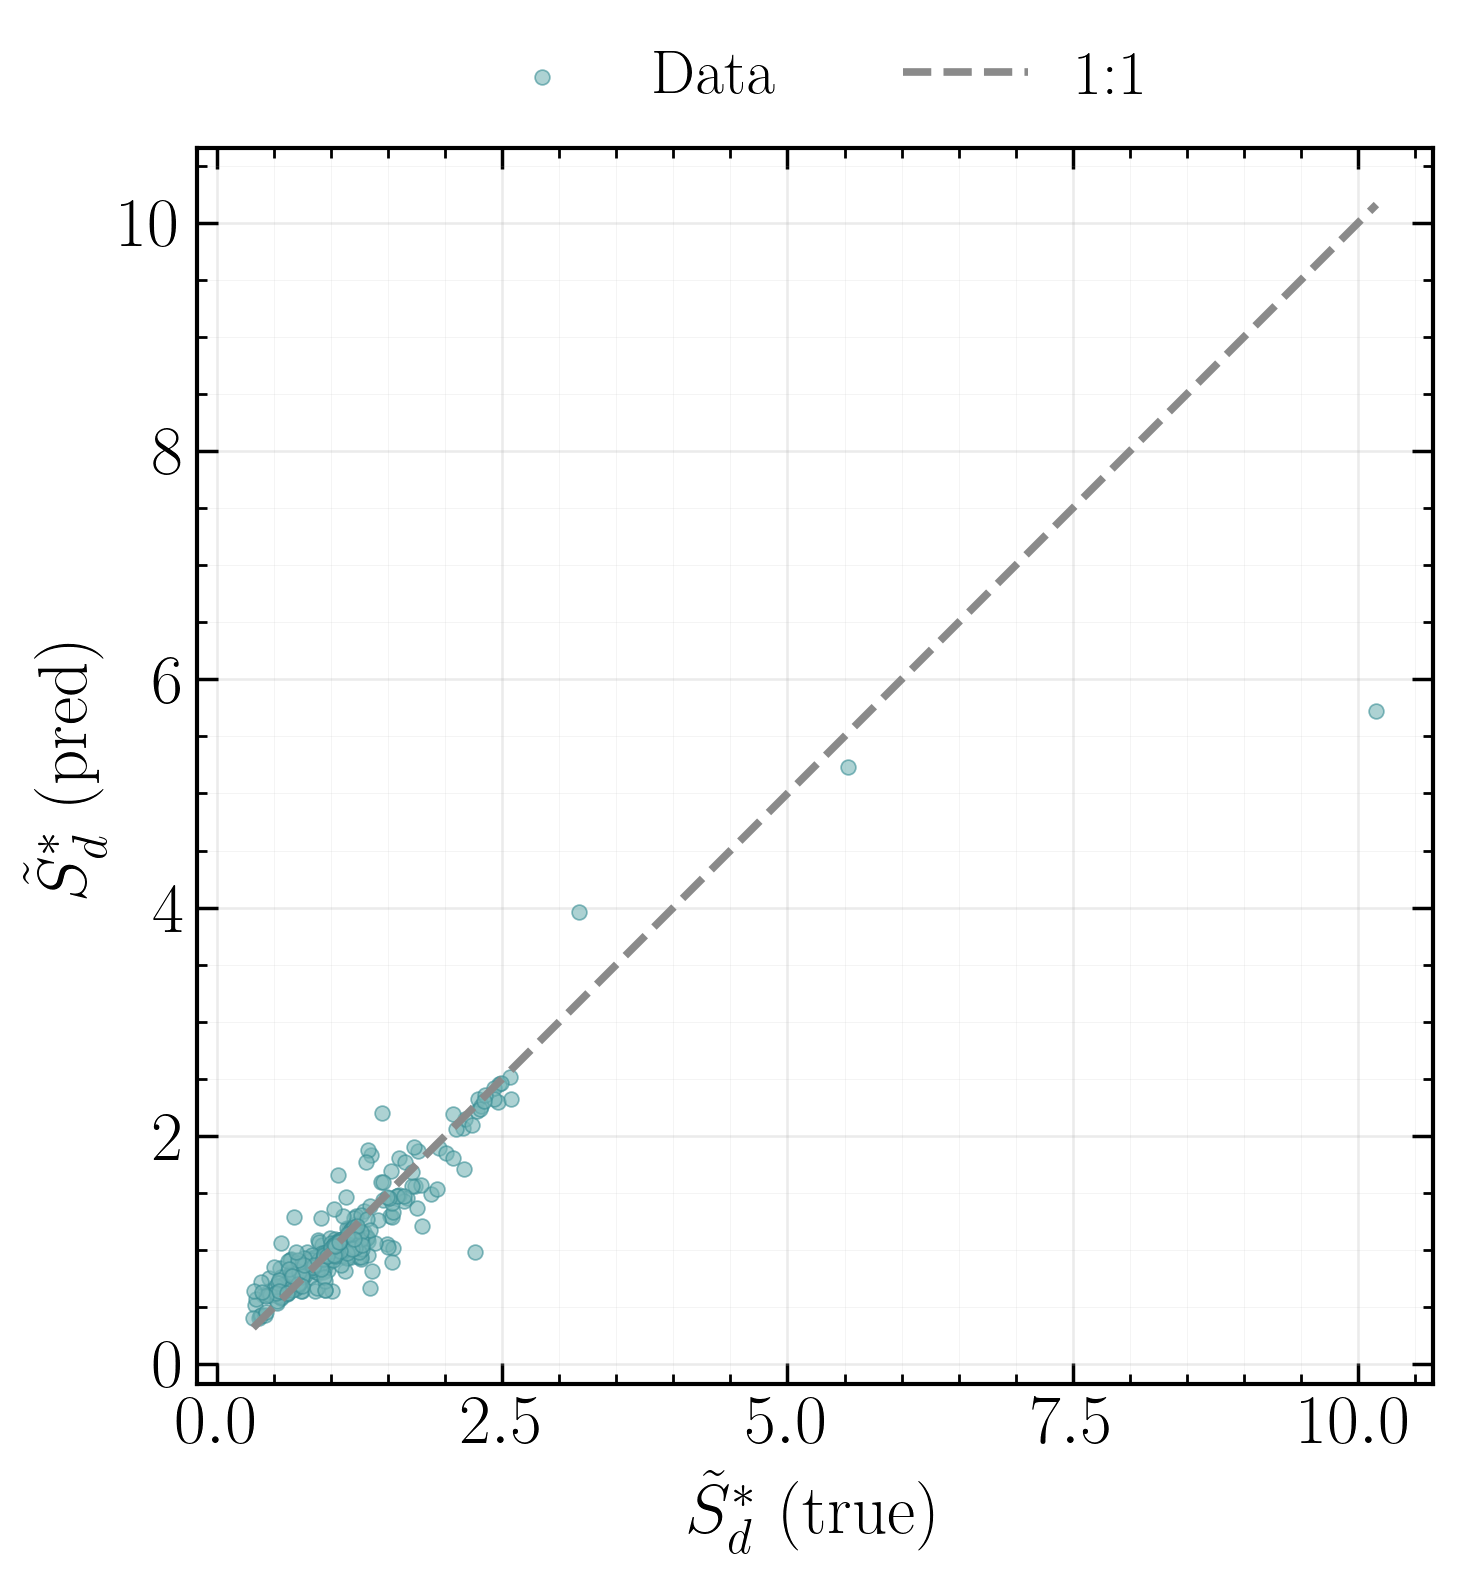

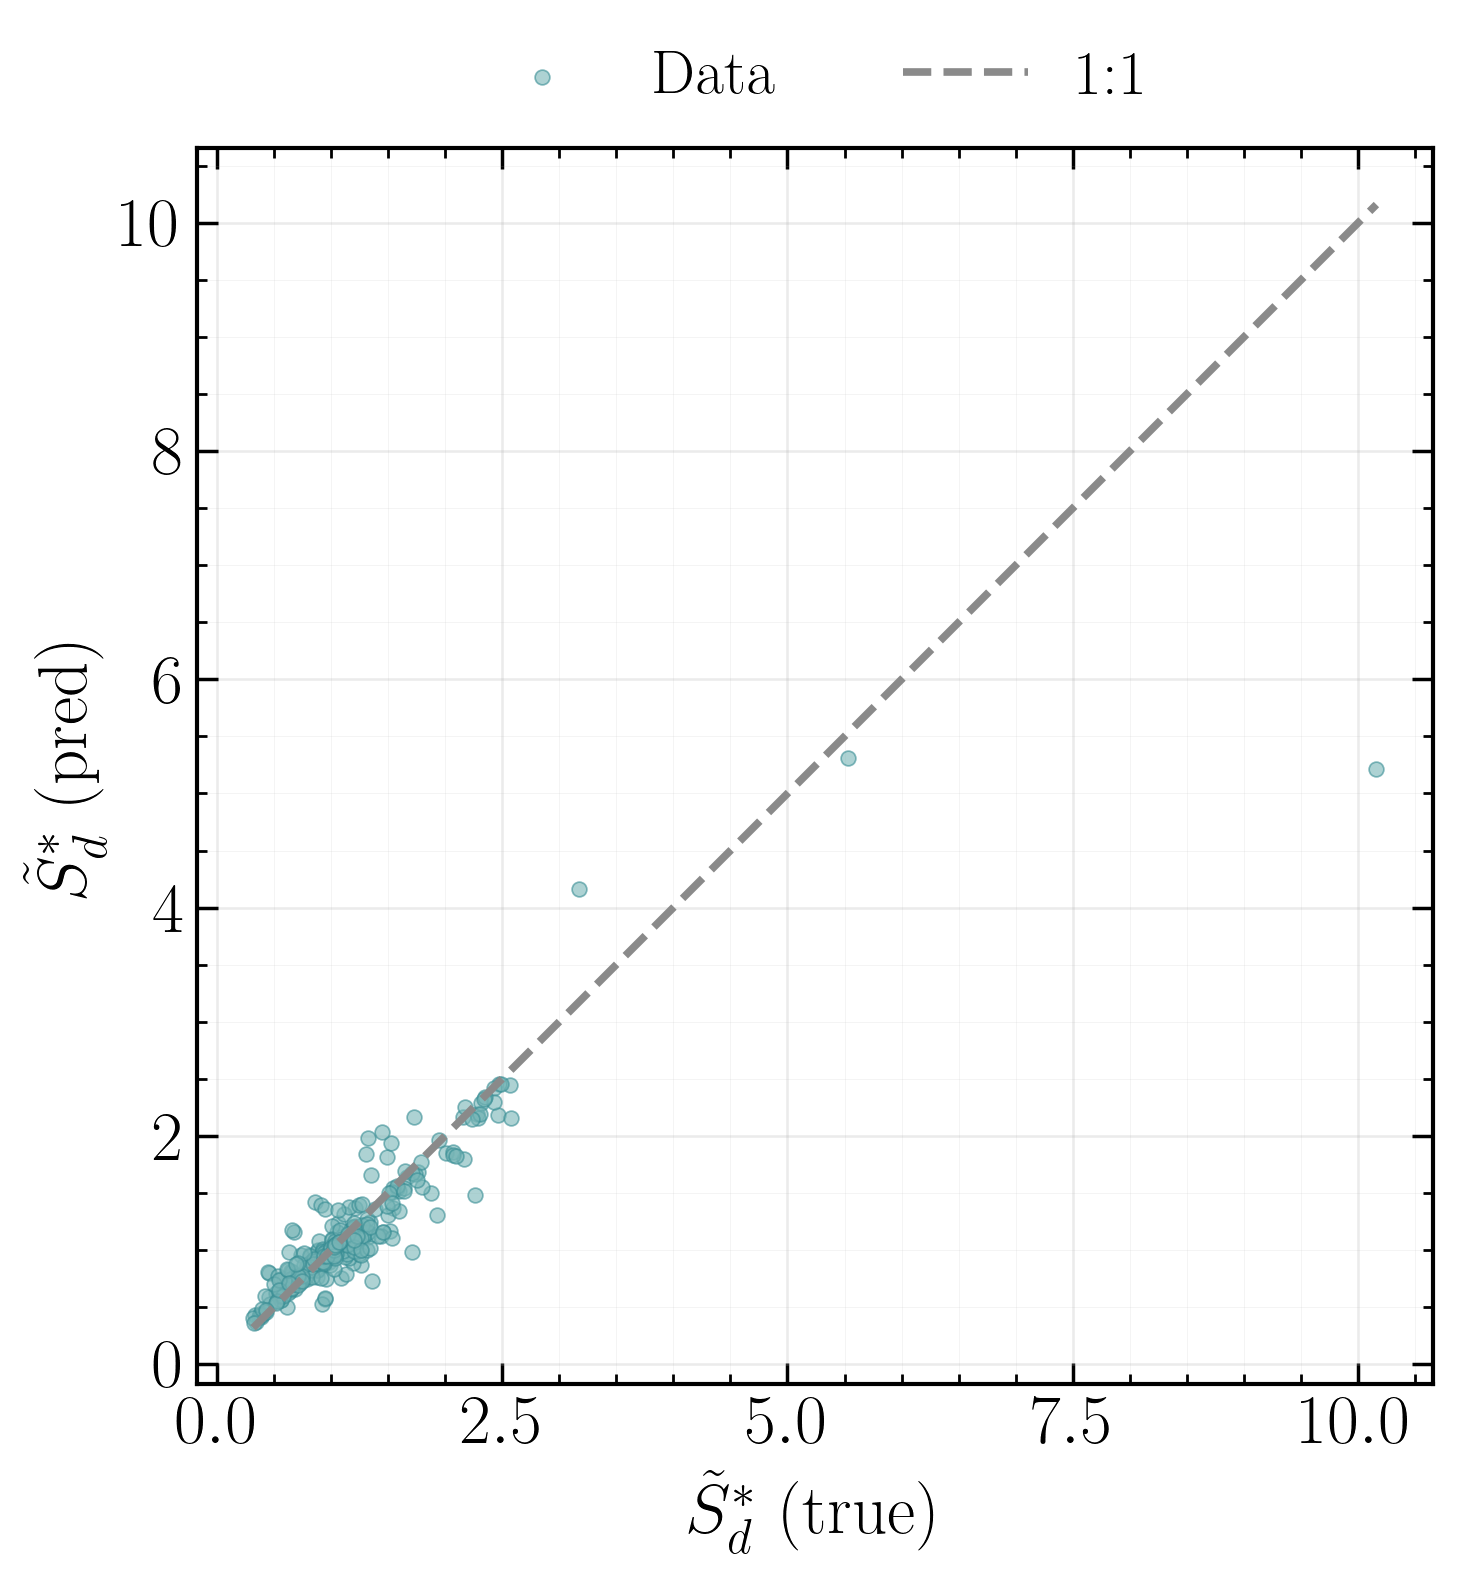


--- Curvature cluster 1 | n=7678 ---


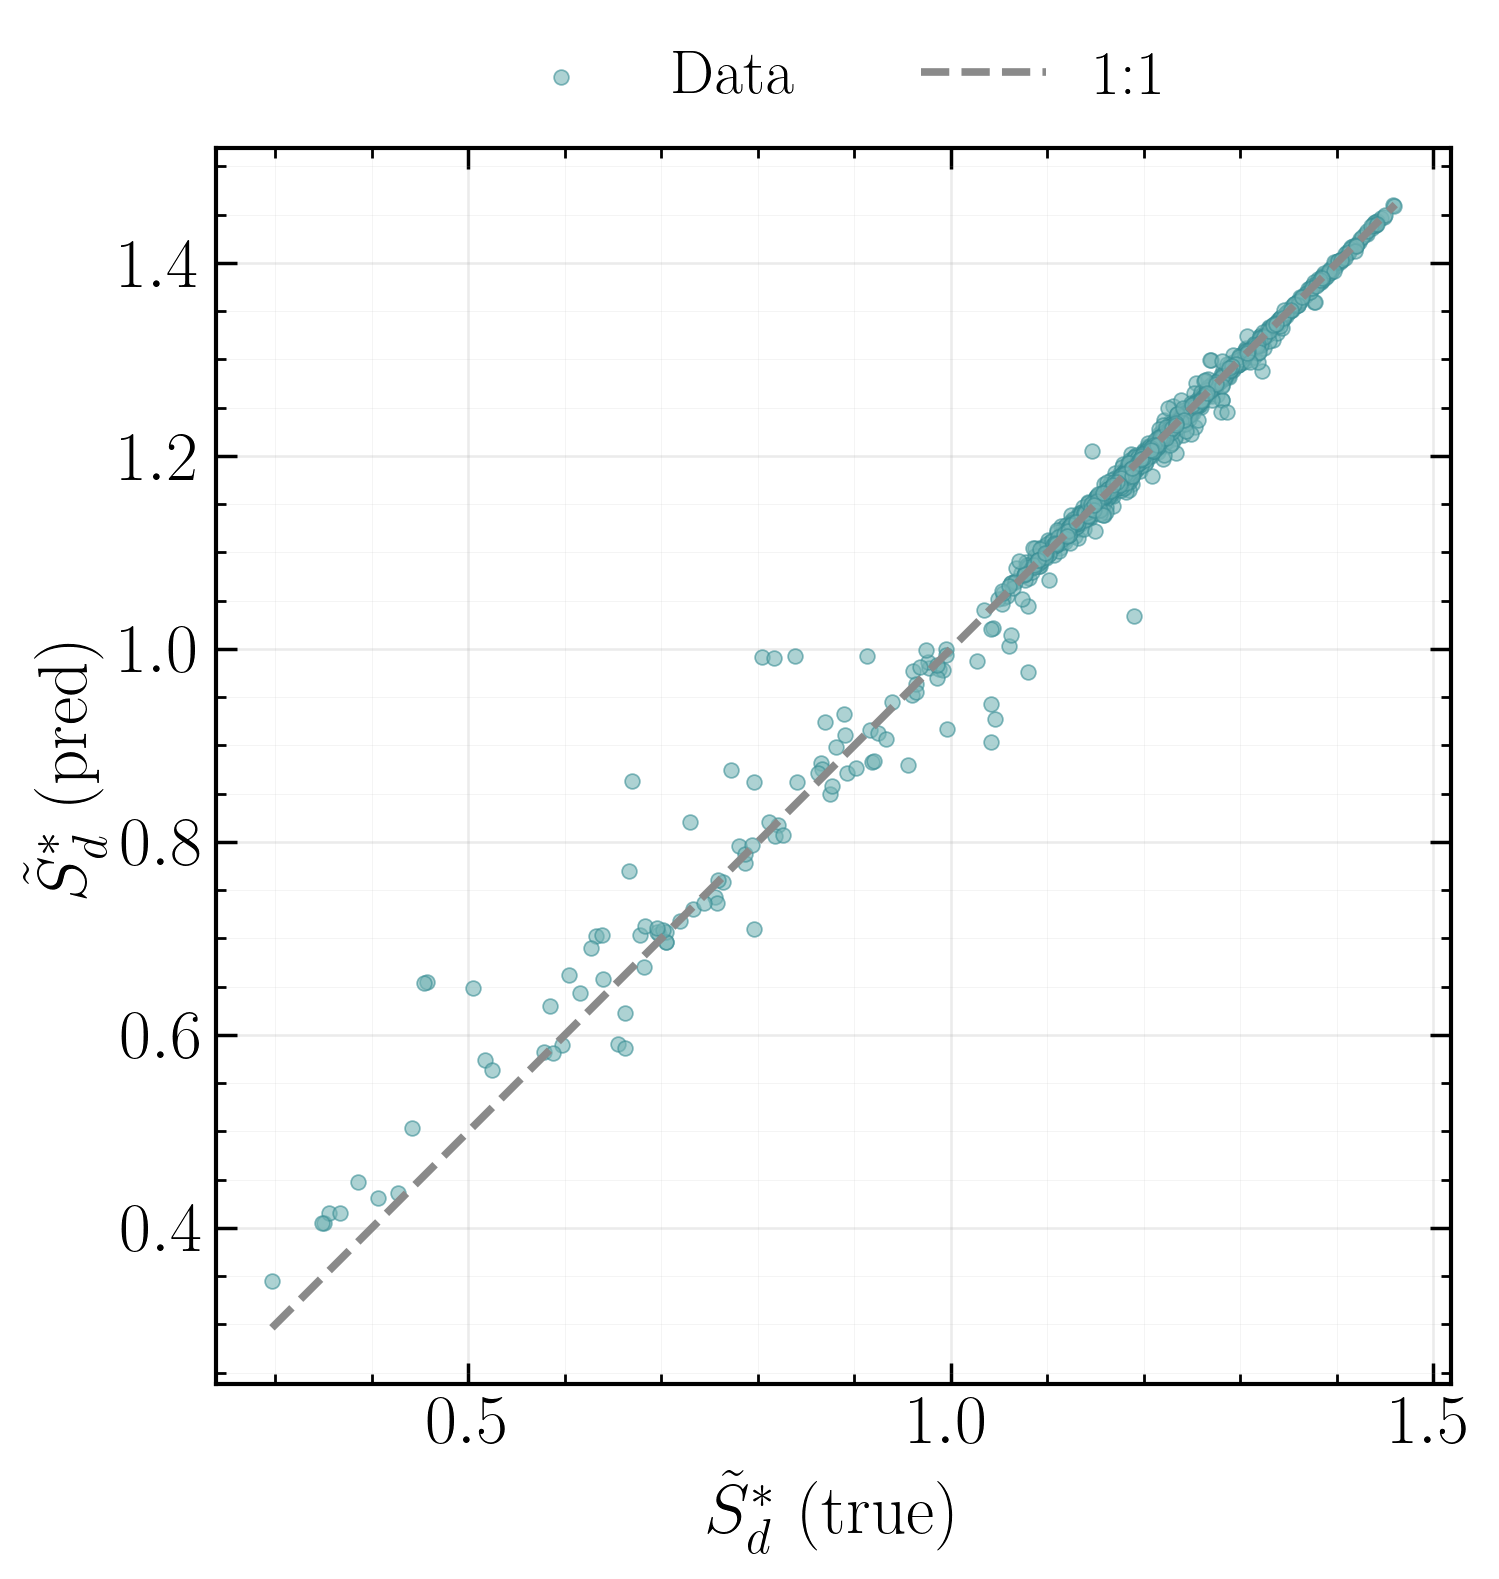

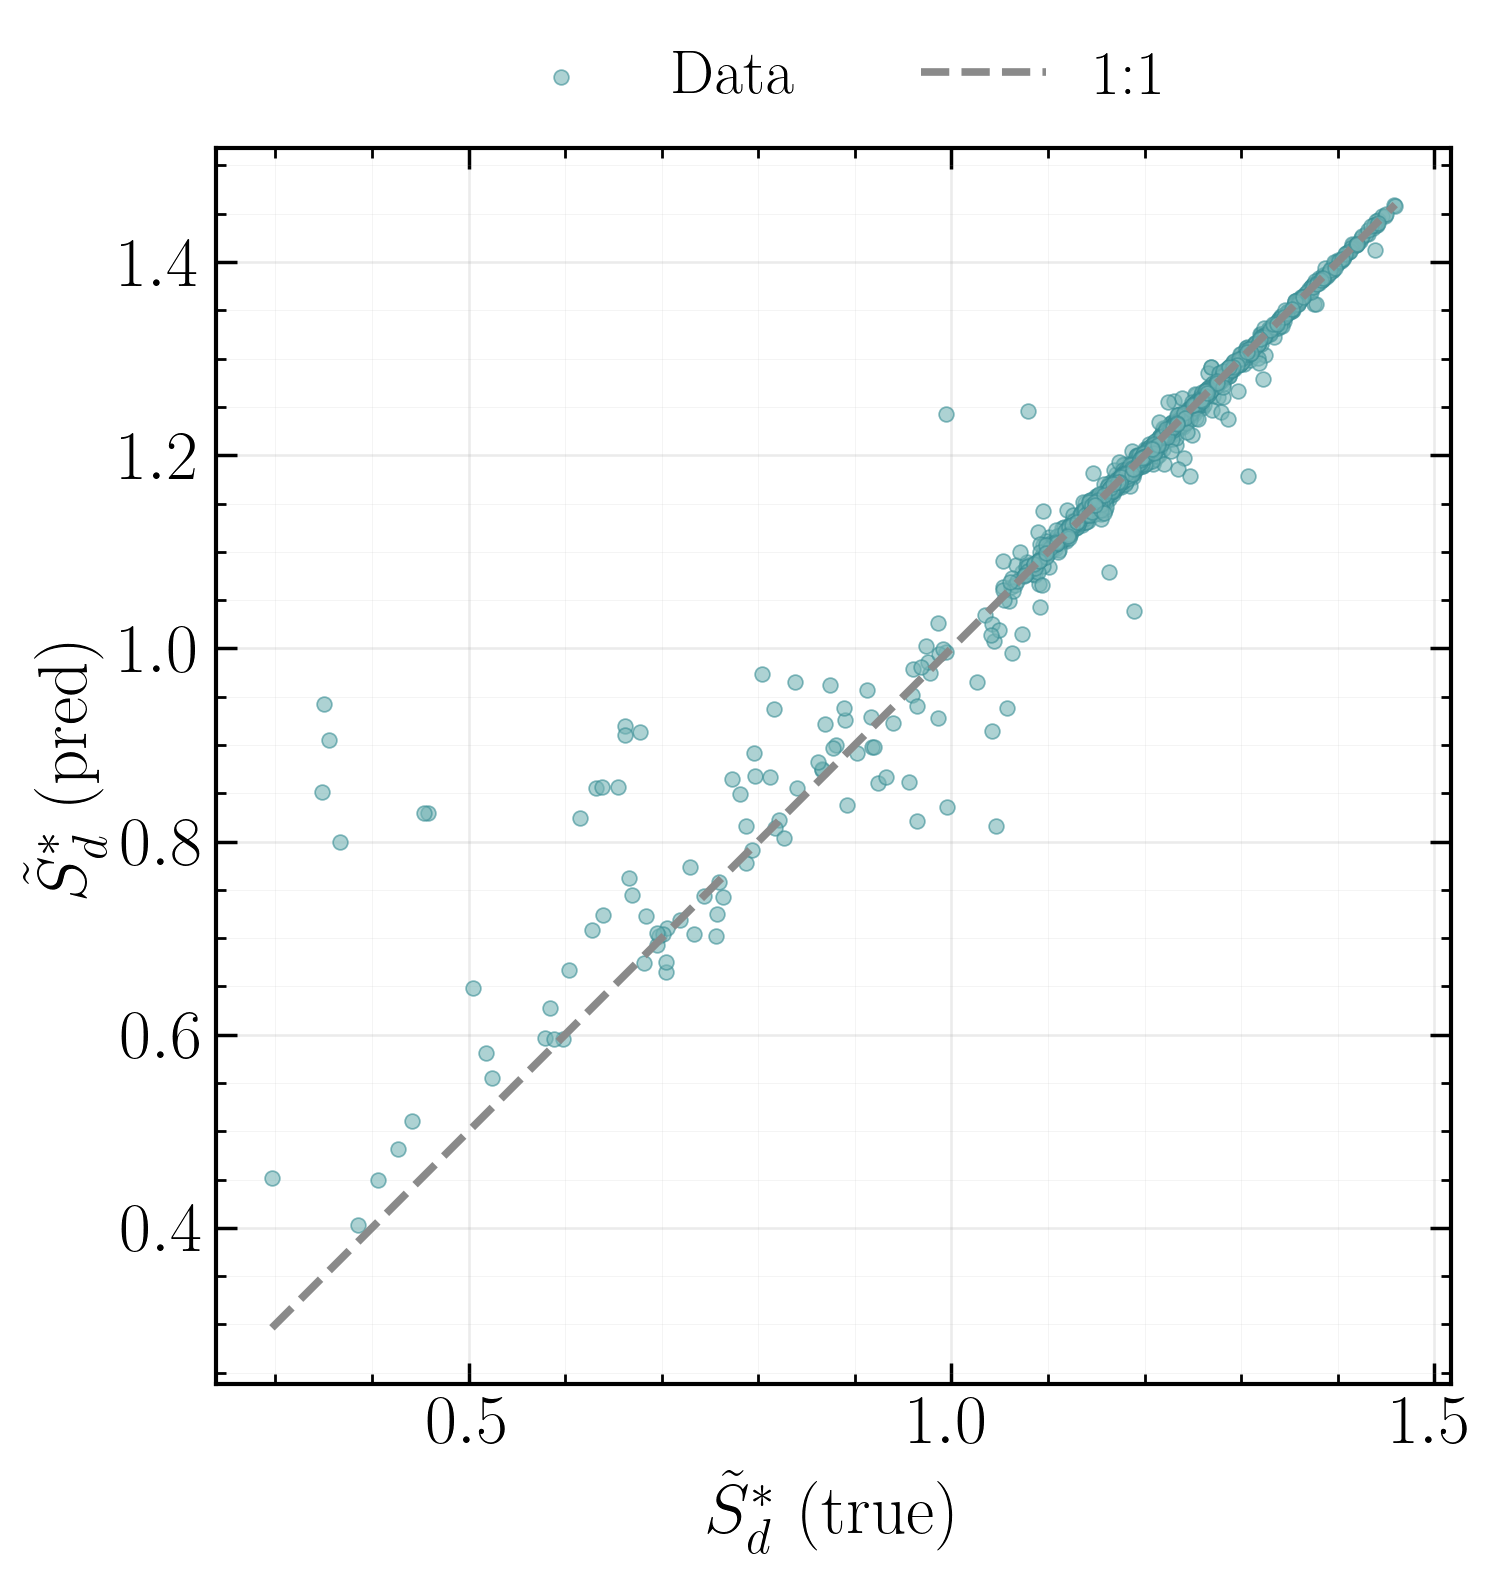

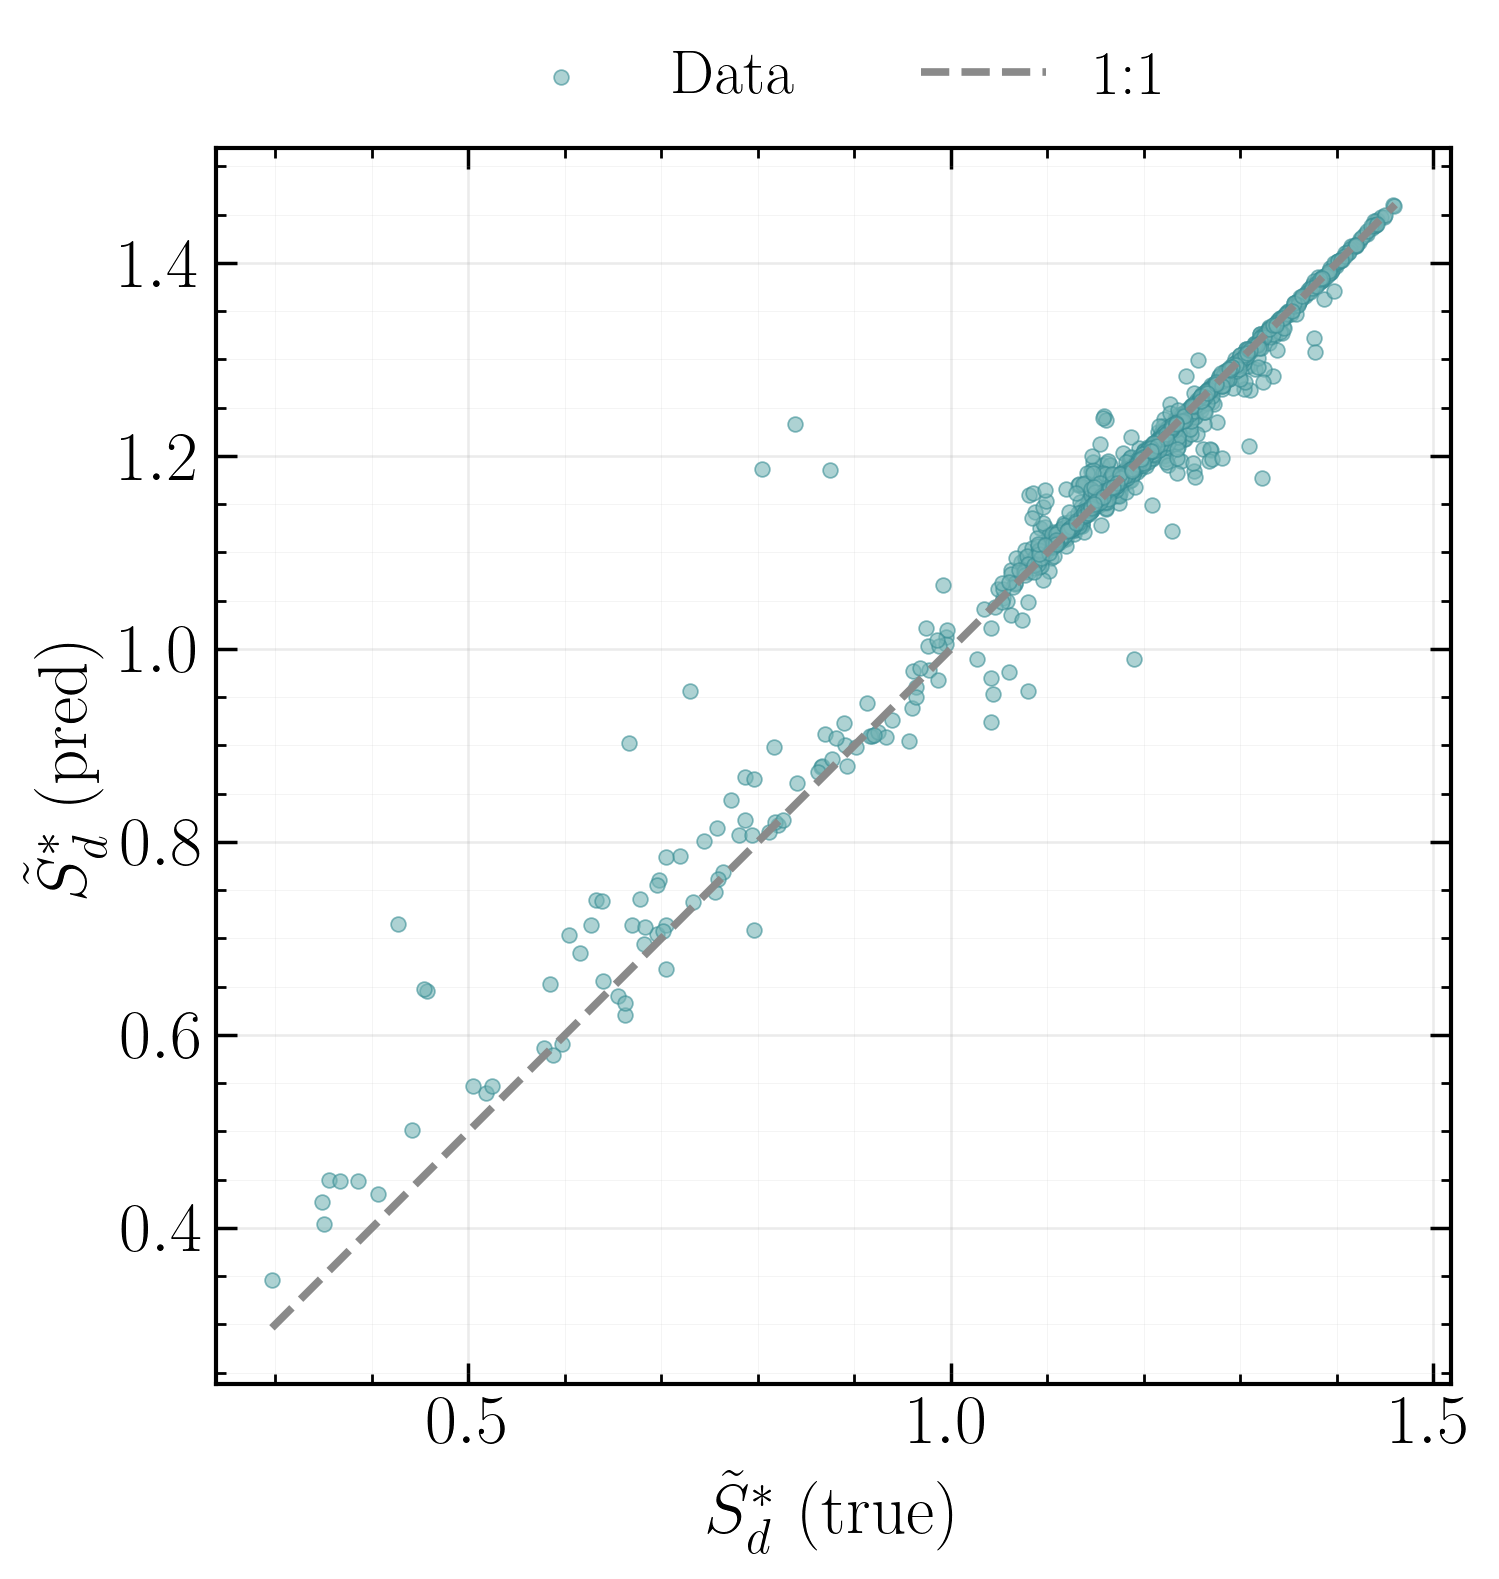


--- Curvature cluster 2 | n=3835 ---


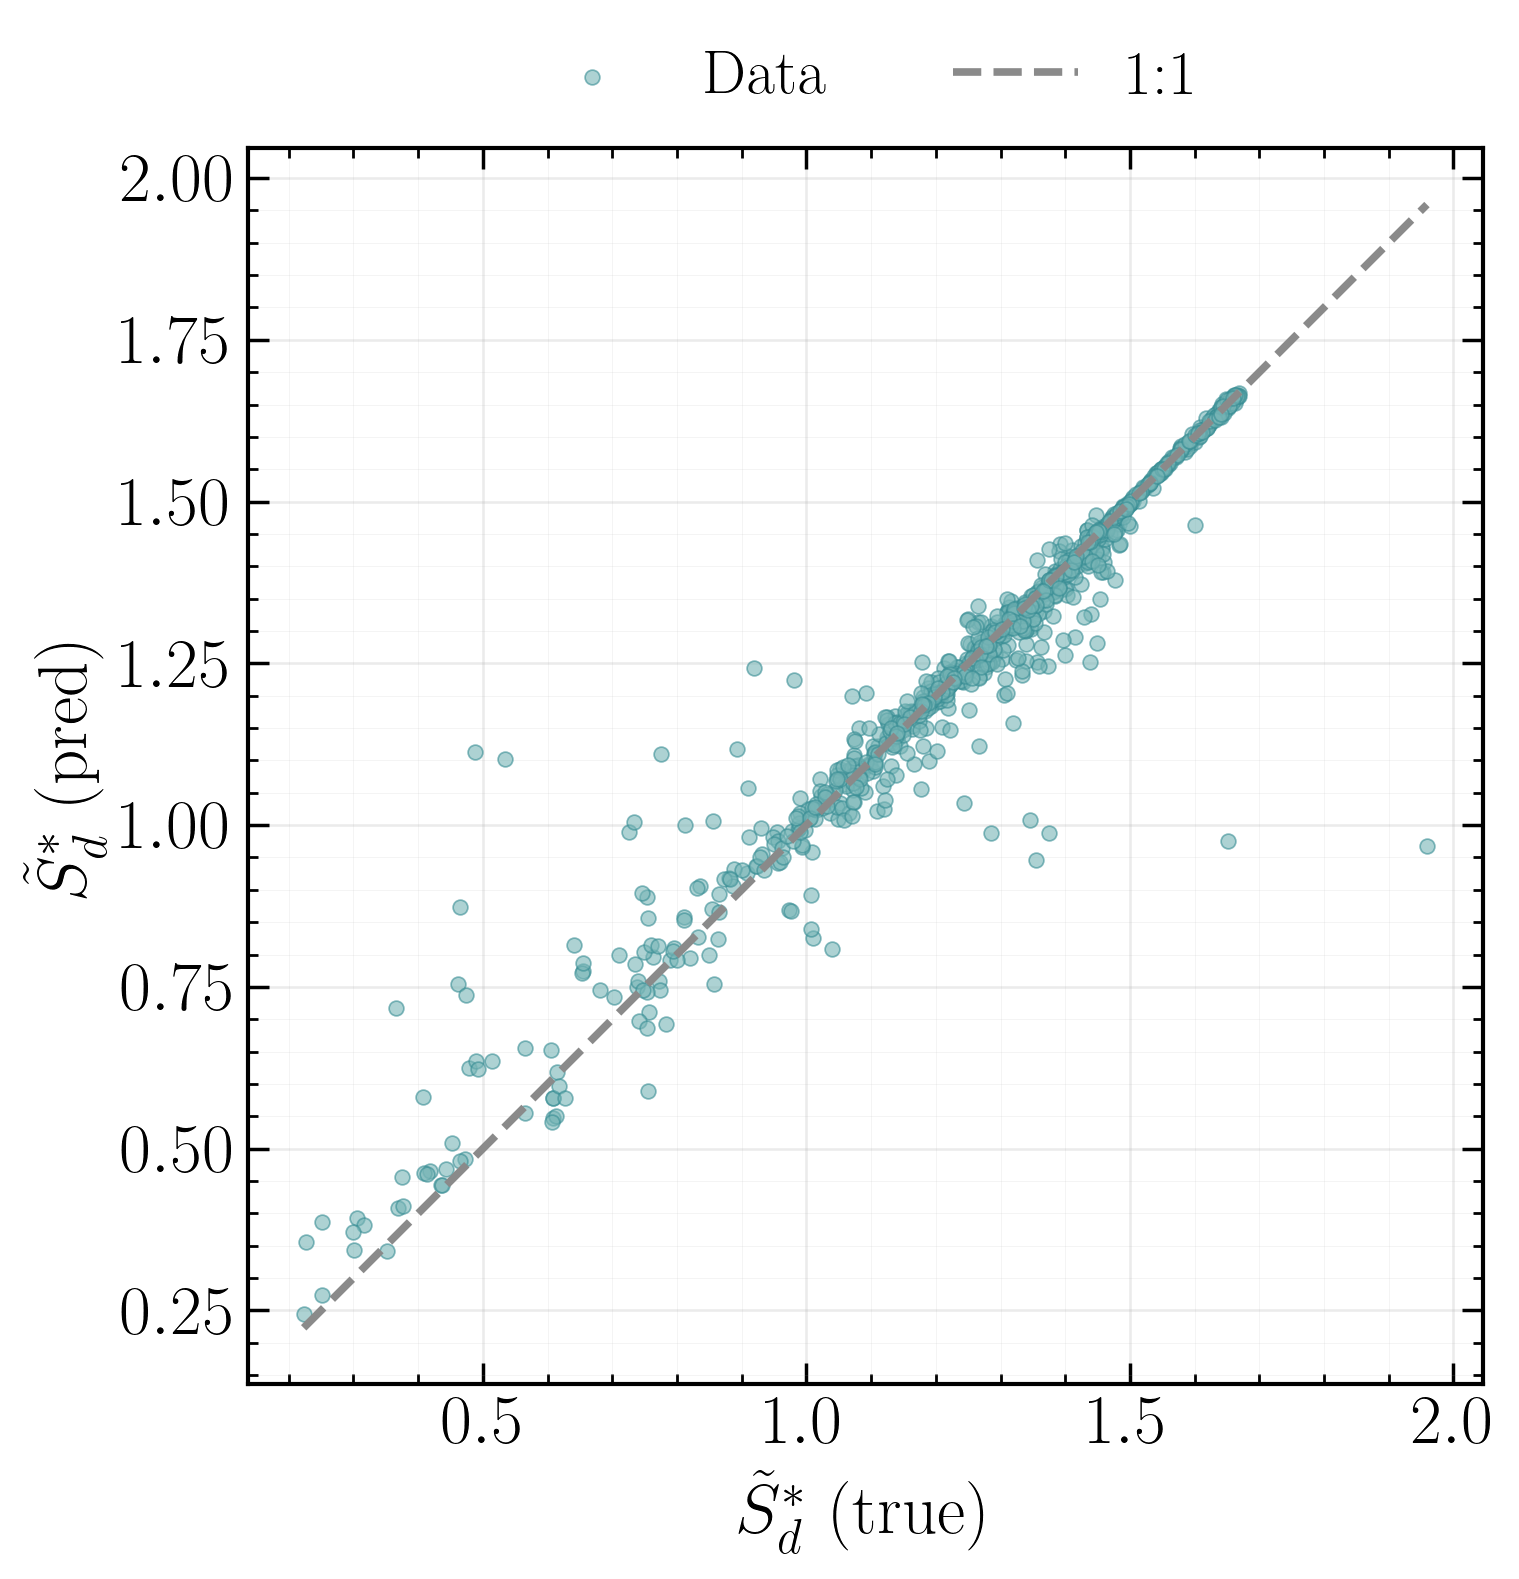

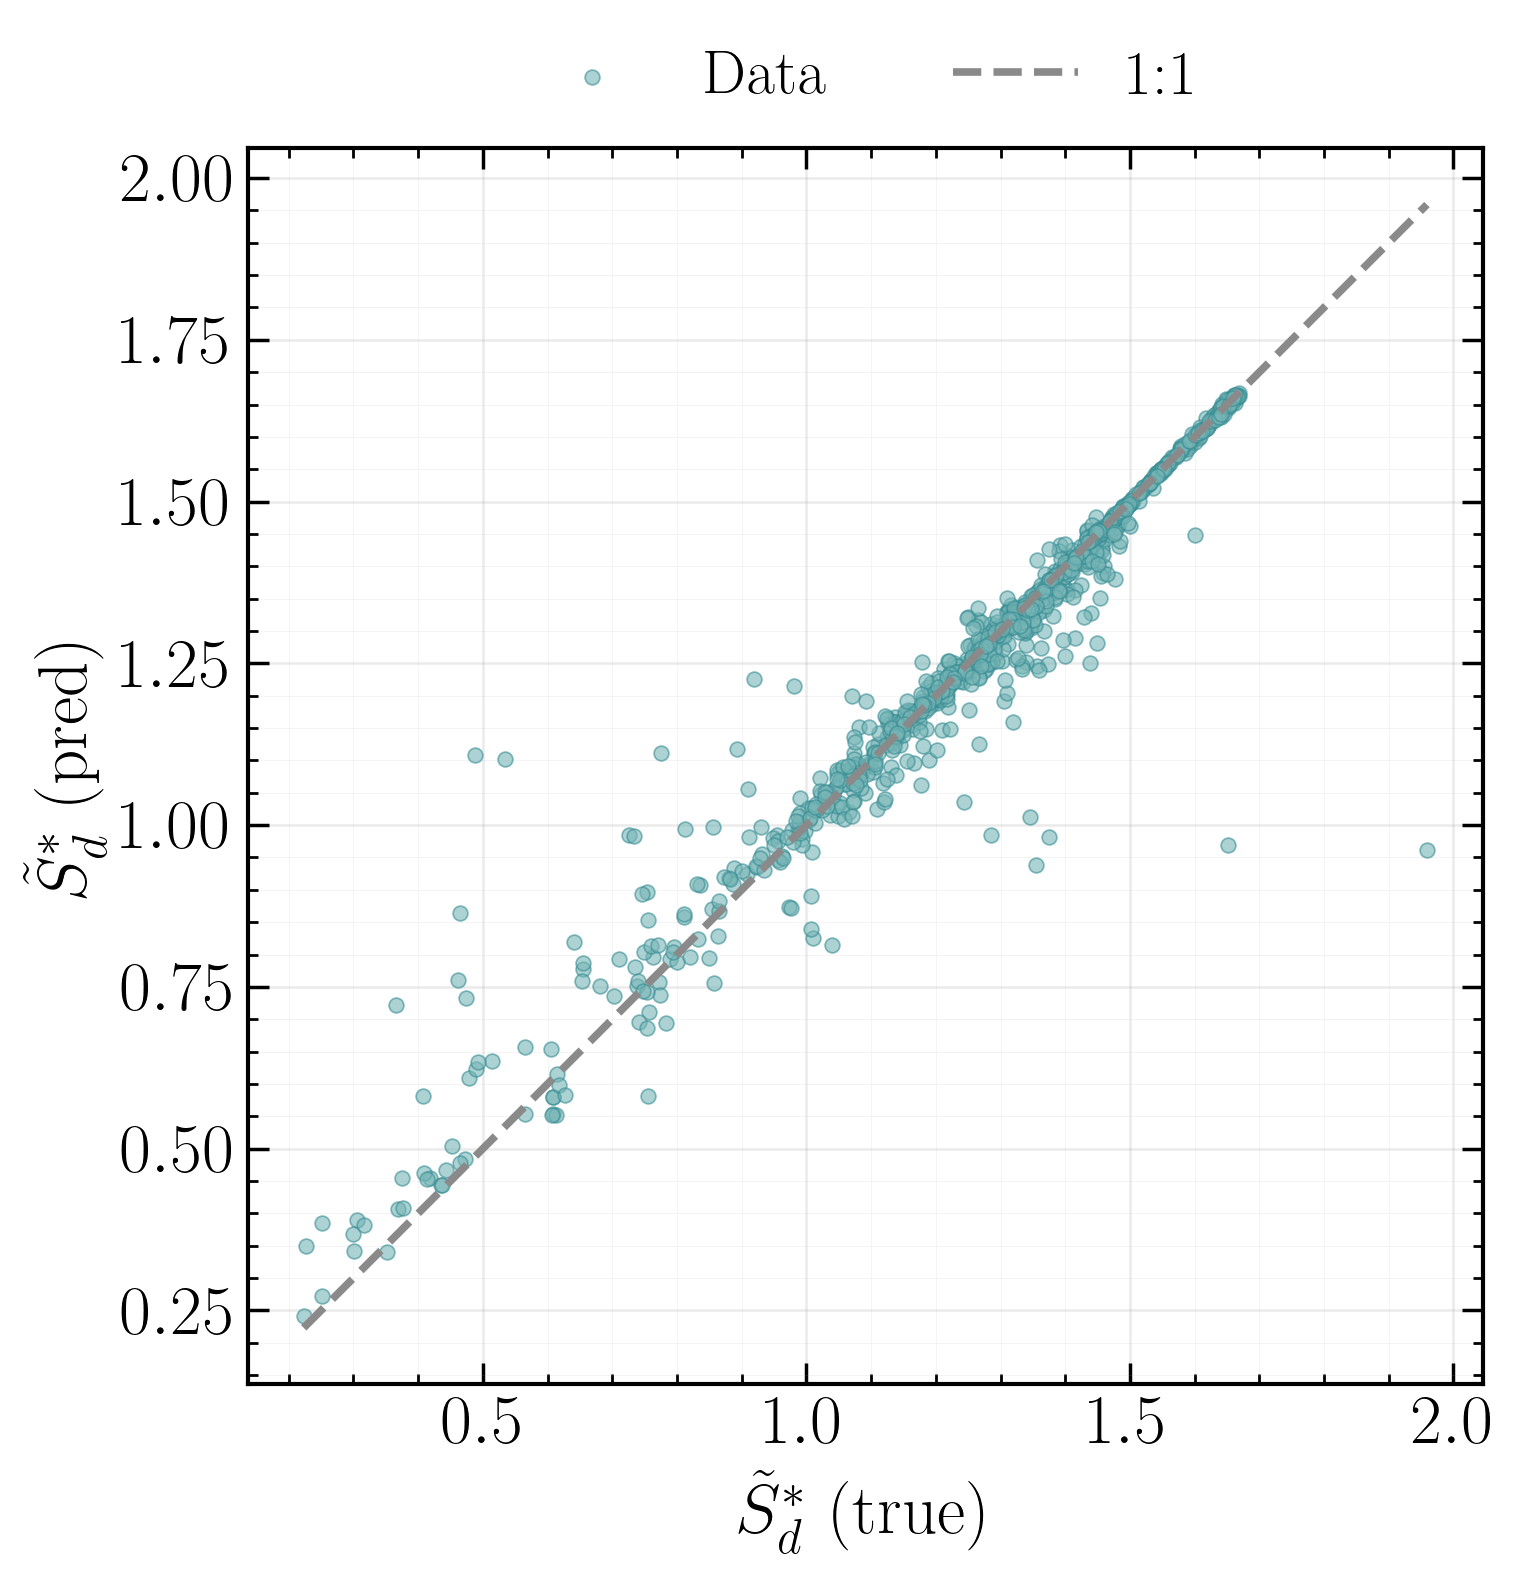

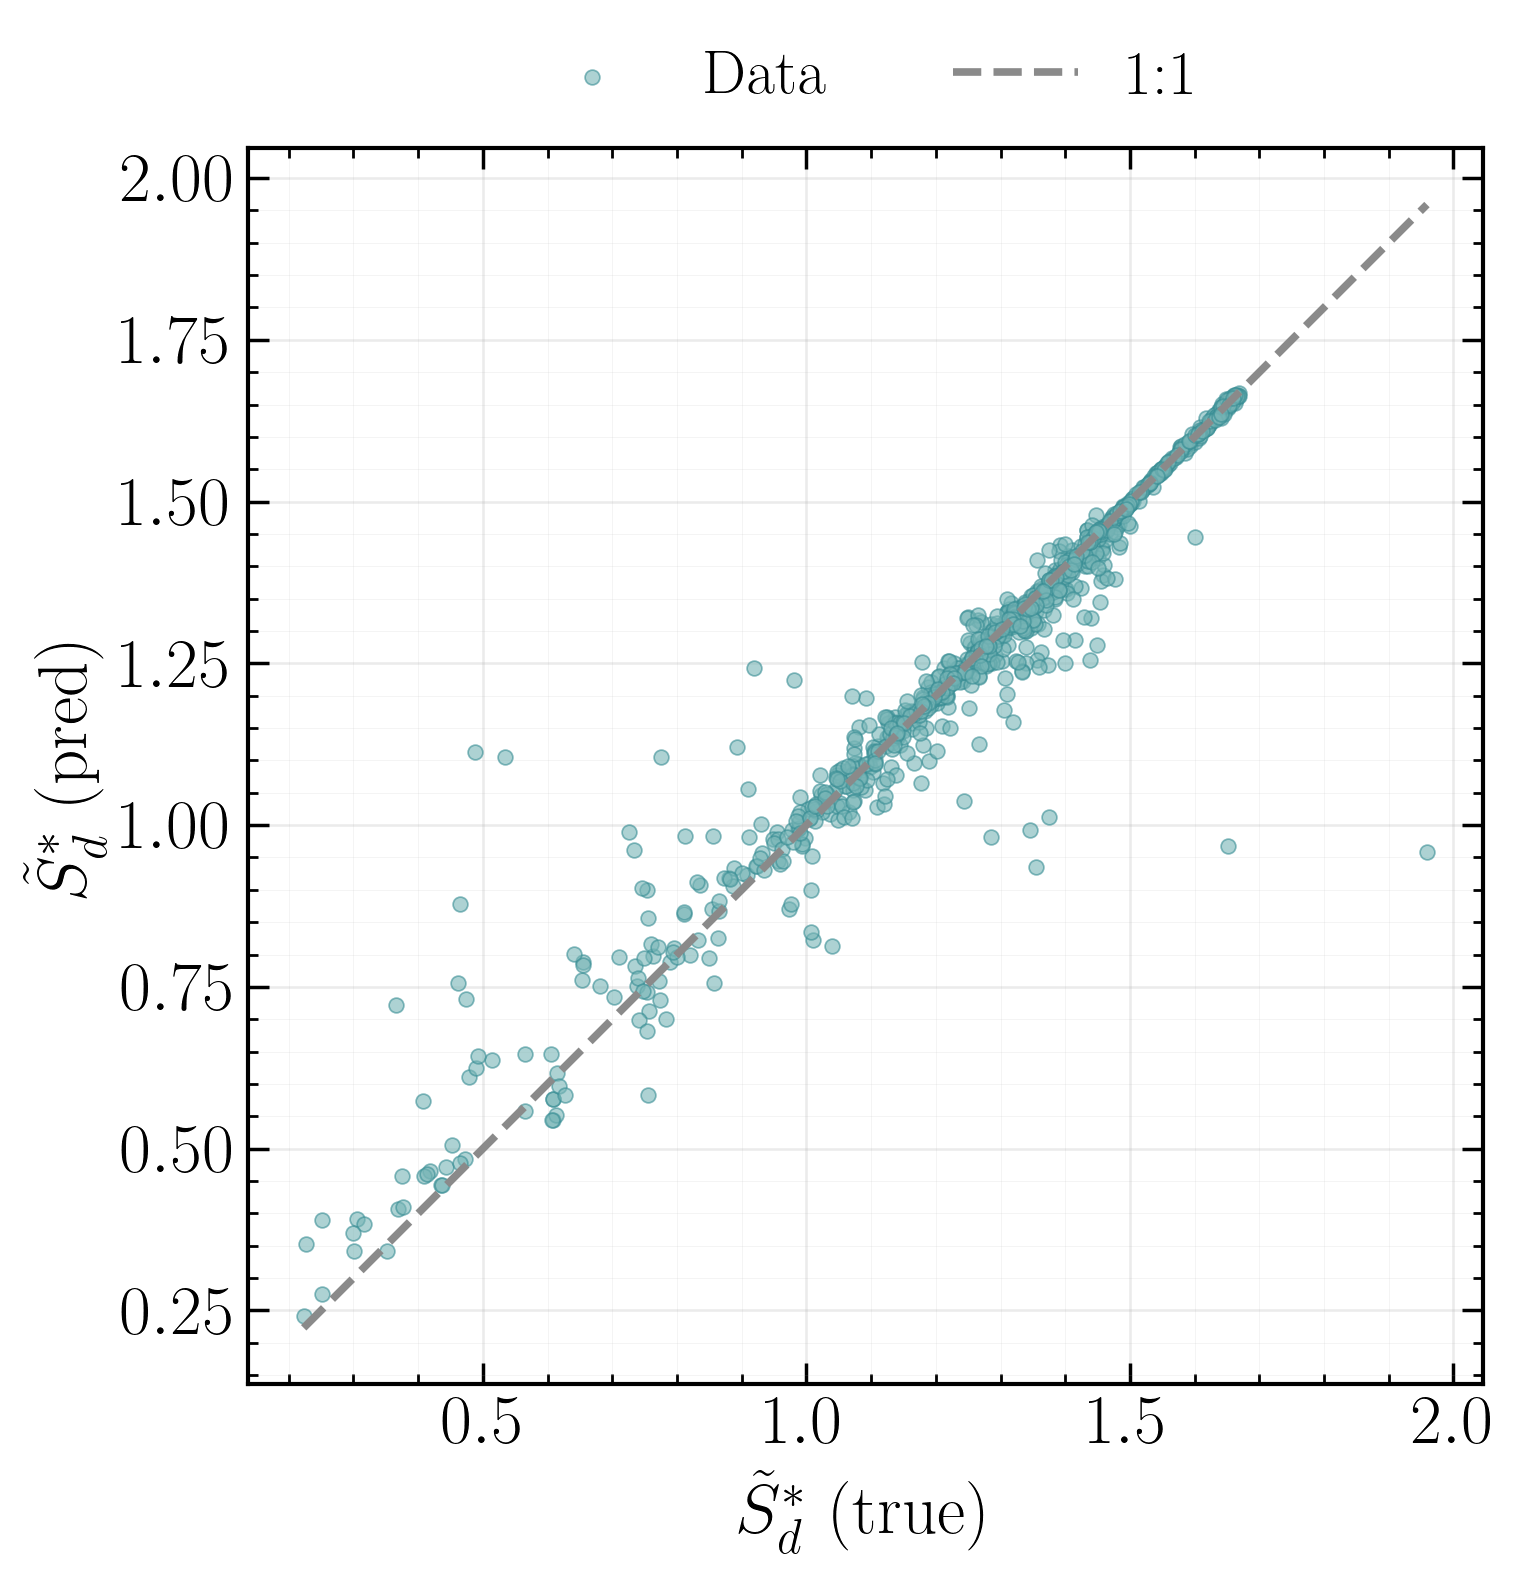


Per-curvature-cluster selection summary:
 cluster   method  n_features                         features       r2     rmse  n_cluster
       0 Backward           4 curvature, dTdx, du_tdy, dcurvdx 0.795438 0.293659       1659
       0     CMIM           4      du_ndy, du_tdx, du_tdy, u_t 0.794526 0.294313       1659
       0      JMI           4   du_ndy, du_tdy, u_t, curvature 0.813164 0.280647       1659
       1 Backward           4           dTdx, u_t, u_n, du_ndy 0.984902 0.016112       7678
       1     CMIM           4           u_t, dTdx, du_tdx, u_n 0.964113 0.024841       7678
       1      JMI           4        u_t, dTdx, du_tdx, du_ndy 0.929628 0.034786       7678
       2 Backward           4           dTdx, u_t, u_n, du_ndy 0.932239 0.072502       3835
       2     CMIM           4           du_ndy, dTdx, u_t, u_n 0.932012 0.072624       3835
       2      JMI           4           du_ndy, u_t, u_n, dTdx 0.932517 0.072353       3835

[INFO] Wrote: /media/alexandros/OS/Us

In [12]:
rows_per_cluster = []

# Helper: get representative set (fallback to full feature set)
rep_features_use = [f for f in rep_features if f in dfc.columns]
if not rep_features_use:
    rep_features_use = list(model_features)

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print()
    print(f"--- Curvature cluster {cl} | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    # --- Backward selection on full feature set (per cluster) ---
    X = sub[rep_features_use].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    bw_sel = run_backward_selection(
        X=X,
        y=y,
        feature_names=rep_features_use,
        n_features_to_select=BACKWARD_N_FEATURES_CLUSTER,
        random_state=RANDOM_STATE,
        scoring=SFS_SCORING,
        cv_splits=SFS_CV_SPLITS,
    )

    if bw_sel:
        r2, rmse, yte, ypred = evaluate_model_rf(sub[bw_sel].to_numpy(), y, TEST_SIZE, RANDOM_STATE)
        plot_pred_vs_true(
            yte,
            ypred,
            title=f"Backward (cluster {cl}) | top-{len(bw_sel)}",
            save_stem=f"pred_vs_true_backward_cluster_{cl}_top{len(bw_sel)}",
        )
        rows_per_cluster.append({
            "cluster": cl,
            "method": "Backward",
            "n_features": len(bw_sel),
            "features": ", ".join(bw_sel),
            "r2": r2,
            "rmse": rmse,
            "n_cluster": int(n_cl),
        })

    # --- JMI/CMIM on representatives (per cluster) ---
    sub_rep = sub.dropna(subset=rep_features_use + [TARGET_VAR])
    if len(sub_rep) < MIN_CLUSTER_SAMPLES:
        print(f"Skipping JMI/CMIM after dropna (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    jmi_sel, _ = select_jmi_features(sub_rep, TARGET_VAR, rep_features_use, K_SELECT_PER_CLUSTER, RANDOM_STATE)
    cmim_sel, _ = select_cmim_features(sub_rep, TARGET_VAR, rep_features_use, K_SELECT_PER_CLUSTER, RANDOM_STATE)

    for method, feats in [("JMI", jmi_sel), ("CMIM", cmim_sel)]:
        if not feats:
            continue
        r2, rmse, yte, ypred = evaluate_model_rf(sub_rep[feats].to_numpy(), sub_rep[TARGET_VAR].to_numpy(), TEST_SIZE, RANDOM_STATE)
        plot_pred_vs_true(
            yte,
            ypred,
            title=f"{method} (cluster {cl}) | top-{len(feats)}",
            save_stem=f"pred_vs_true_{method.lower()}_cluster_{cl}_top{len(feats)}",
        )
        rows_per_cluster.append({
            "cluster": cl,
            "method": method,
            "n_features": len(feats),
            "features": ", ".join(feats),
            "r2": r2,
            "rmse": rmse,
            "n_cluster": int(n_cl),
        })

# --- Save per-cluster summary ---
if rows_per_cluster:
    per_df = pd.DataFrame(rows_per_cluster)
    per_csv = SAVE_DIR / "feature_selection_per_curvature_cluster_summary.csv"
    per_df.to_csv(per_csv, index=False)
    print()
    print("Per-curvature-cluster selection summary:")
    print(per_df.sort_values(["cluster", "method"]).to_string(index=False))
    print()
    print(f"[INFO] Wrote: {per_csv}")
else:
    print("[WARN] No per-cluster selection results.")
